# 本文件说明
- 统计分析

# 基本设置

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import time

import requests,json
from sklearn.externals import joblib

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from toolkits.setup.date_time import get_day_list
from toolkits.setup import specific_func
specific_func.set_ch_pd()

## 一些函数

In [3]:
def plot_cor(count_data, day_thing, title):
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    rects = count_data[['al_cor', 'al_uncor']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('num', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['al-cor', 'al-uncor'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    count_data[['al_cor_rate', 'al_uncor_rate']].plot(x = count_data['publishtime'],
                                              kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(['al-cor-rate', 'al-uncor-rate'], loc='upper center')

    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in count_data['publishtime'].tolist():
            x = count_data['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()
    
    now = datetime.datetime.now().strftime("%Y-%m-%d")
    plt.savefig("figure\plot_cor\%s_%s.jpg"%(now, title))

    print(count_data.sort_values(by = 'publishtime', ascending = False).head())

In [4]:
def plot_tend(tend_count, day_thing, title):
    tend_counts = tend_count.set_index(["tendency", 'publishtime']).unstack('tendency')
    tend_counts.columns = ['neg', 'pos']
    tend_counts['sum'] = tend_counts.sum(axis = 1)
    tend_counts['neg_rate'] =  tend_counts['neg'] / tend_counts['sum']
    tend_counts['pos_rate'] =  tend_counts['pos'] / tend_counts['sum']
    tend_counts = tend_counts.reset_index('publishtime')

    tend_counts = tend_counts.sort_values(by = 'publishtime')
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    tend_counts[['neg', 'pos']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('N', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['neg N', 'pos N'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    tend_counts[['neg_rate', 'pos_rate']].plot(x = tend_counts['publishtime'],
                                             kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper center')
    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in tend_counts['publishtime'].tolist():
            x = tend_counts['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()
    
    now = datetime.datetime.now().strftime("%Y-%m-%d")
    plt.savefig("figure\plot_tend\%s_%s.jpg"%(now, title))
    
    print(tend_counts.sort_values(by = 'publishtime', ascending = False).head())

In [5]:
def get_server_res(data, url):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
    elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i]['cor']])
    parse_data = pd.DataFrame(parse_data, columns = ['id', 'cor'])    
    return parse_data, elapsed_time

In [6]:
def get_server_res_yjh(data, url, col_name):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
#     elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i][col_name]])
    parse_data = pd.DataFrame(parse_data, columns = ['id', col_name])    
    return parse_data #, elapsed_time

In [7]:
def get_period_data_for_training(human_additional, warning, url, folder, filename, flag):
    combined_data = pd.concat([human_additional, warning])
    print('去重前', combined_data.shape)
    combined_data = combined_data.drop_duplicates(subset = 'id')
    print('去重后', combined_data.shape)

    # predict
    data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
    if flag == 'circ':
        parse_data, elapsed_time = get_server_res(data, url)
    elif flag == 'cbrc':
        col_name = 'sec'
        parse_data = get_server_res_yjh(data, url, col_name)
        
    print(parse_data.shape)
    # parse_data.head()  

    parse_data.columns = ['id', 'predict_label']
    parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
    parse_data['label'] = ''
    # parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
    # parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
    print(parse_data.shape)
    # parse_data.head()

    combined_data = pd.merge(combined_data, parse_data, on  = 'id')
    print(combined_data.head())

    file_path = '%s/result/%s'%(folder, filename)
    combined_data[['id', 'predict_label', 
                   'label', 'title', 'content']].to_excel(file_path, index = False)

In [8]:
def get_class_data(class_count):
    class_count['c'] = class_count['publishtime'] + class_count['classify']
    class_count.index = range(class_count.shape[0])
    combined_count = {}
    for index in class_count.index:
        c = class_count.loc[index, 'c']
        if c not in combined_count:
            combined_count[c] = {}
            combined_count[c]['count'] = class_count.loc[index, 'count']
        else :
            combined_count[c]['count'] = combined_count[c]['count'] + class_count.loc[index, 'count']

        combined_count[c]['publishtime'] = class_count.loc[index, 'publishtime']
        combined_count[c]['classify'] = class_count.loc[index, 'classify']

    class_count = pd.DataFrame().from_dict(combined_count, orient = 'index')
    class_count.index = range(class_count.shape[0])    

    cor_class = class_count.set_index(['publishtime', 'classify']).unstack()#.reset_index('publishtime')
    cor_class['总量'] = cor_class['count'].sum(axis = 1)
    cor_class_1 = cor_class.copy()
    cor_class_1['非噪音'] = cor_class_1['总量'] - cor_class_1['count', '噪音']
    cor_class_1['非噪音-比例'] = cor_class_1['非噪音'] / cor_class_1['总量']
    cor_class_1['噪音-比例'] = cor_class_1['count', '噪音'] / cor_class_1['总量']
    # cor_class_1.sort_index(ascending = False).head()    
    
    for k in cor_class['count'].columns.tolist():
        cor_class['rate', k] = cor_class['count', k] / cor_class['总量']
#     cor_class.sort_index(ascending = False).head()

    count_data_7 = cor_class_1[['总量',  '非噪音', '非噪音-比例', '噪音-比例']]
    count_data_7.insert(2, '噪音', cor_class_1['count', '噪音'])
    count_data_7.columns = ['sum', 'al_cor', 'al_uncor', 'al_cor_rate', 'al_uncor_rate']
    count_data_7 = count_data_7.reset_index()

    cor_list = ['产品销售', '资本市场', '其他相关报道', '噪音'] # 3、4、7、8   
    count_data_4 = cor_class_1['count'][cor_list].sum(axis = 1).reset_index()
    ss = cor_class_1.reset_index()
    count_data_4 = pd.merge(count_data_4, ss[['总量', 'publishtime']], on = 'publishtime')
    count_data_4.columns = ['publishtime', 'al_uncor', 'sum']
    count_data_4['al_cor'] = count_data_4['sum'] - count_data_4['al_uncor']
    count_data_4['al_cor_rate'] = count_data_4['al_cor'] / count_data_4['sum']
    count_data_4['al_uncor_rate'] = count_data_4['al_uncor'] / count_data_4['sum']

    return cor_class_1, cor_class, count_data_7, count_data_4

In [9]:
# add_count = cbirc_add[cbirc_add['type'] == '建行北分']
# cbirc_day_thing
# title = "（建行北分）人工补录"
def plot_add(add_count, cbirc_day_thing, title):
    add_count = add_count.groupby('publishtime')['count'].sum()
    add_count = add_count.reset_index(['publishtime'])
    add_count = add_count.sort_values(by = 'publishtime')
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    add_count.plot(x = 'publishtime', y = 'count', kind = 'bar', figsize = (15, 6), ax = ax1)
    ax1.set_ylabel('数据量', fontsize = 16)
    ax1.set_title(title, fontsize = 20)

    ax2 = ax1.twinx()  # this is the important function
    ax2.set_ylim(0, 1)
    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in cbirc_day_thing:    
        if d in add_count['publishtime'].tolist():
            x = add_count['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()

    print(add_count.sort_values(by = 'publishtime', ascending = False).head())

# 参数设置

In [10]:
today = datetime.datetime.now()
today_str = today.strftime("%Y-%m-%d")
yesterday = today - datetime.timedelta(days=1)
yesterday_str = yesterday.strftime("%Y-%m-%d")
# data_folder = r'D:\XH\OneDrive\网智天元\4 银保监会\cbirc_获取用于人工判断数据\%s'% yesterday_str
# if not os.path.exists(data_folder):
#     os.makedirs(data_folder)

print('今天是：',today.strftime("%Y-%m-%d"))
print('昨天是：',yesterday_str)
print('统计的是昨天的数据，即 %s 的数据'%yesterday_str)
# print('文件存储位置: ', data_folder)

start_day = today - datetime.timedelta(days=31) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = today_str # yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

今天是： 2018-12-27
昨天是： 2018-12-26
统计的是昨天的数据，即 2018-12-26 的数据
start_day： 2018-11-26
end_day： 2018-12-27


In [11]:
label_dic={'补录':0,'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,
           '消费服务':6,'其他相关报道':7,'噪音':8,'交通':9,'环保':10}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{0: '补录',
 1: '监管',
 2: '行业',
 3: '产品销售',
 4: '资本市场',
 5: '公司内部管理',
 6: '消费服务',
 7: '其他相关报道',
 8: '噪音',
 9: '交通',
 10: '环保'}

In [12]:
group = '1-新闻，2-论坛，3-博客，4-微博，5-纸媒，6-视频，7-外媒，8-广播，9-电视，11-微信，13-新闻客户端，15-推特'
group_dict = dict([x.split('-') for x in group.split('，')])
group_dict

{'1': '新闻',
 '11': '微信',
 '13': '新闻客户端',
 '15': '推特',
 '2': '论坛',
 '3': '博客',
 '4': '微博',
 '5': '纸媒',
 '6': '视频',
 '7': '外媒',
 '8': '广播',
 '9': '电视'}

In [13]:
proj_dic={'银监会':1,'保监会':2,'中国人寿':3,'建行北分':4,'中国人保':5,'安徽银监局':6}
proj_name_dict = {v: k for k, v in proj_dic.items()}
proj_name_dict

{1: '银监会', 2: '保监会', 3: '中国人寿', 4: '建行北分', 5: '中国人保', 6: '安徽银监局'}

# 保险业--旧
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：

## 特殊时间点

In [14]:
engine = specific_func.get_engine('circ')

In [15]:
circ_day_thing = [['2018-05-31', '上线倾向性模型'], 
             ['2018-06-12', '更新倾向性模型'], 
             ['2018-06-13', '更新倾向性模型'], 
             ['2018-06-15', '更新相关性模型'], 
             ['2018-06-19', '修复bug'], 
             ['2018-06-24', '更新相关性模型'],
             ['2018-06-24', '上线预警模型'], 
             ['2018-06-25', '更新相关性模型（加入交集数据作为噪音）']]

## 八分类

In [16]:
# 相关数据
sql_circ_cor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.classify, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.classify \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_cor_count = pd.read_sql(sql_circ_cor, engine)
circ_cor_count['classify'] = circ_cor_count['classify'].apply(lambda x:class_name_dict[x])
circ_cor_count.head()

,publishtime,classify,count
0,2018-12-27,补录,2
1,2018-12-27,监管,1124
2,2018-12-27,行业,818
3,2018-12-27,产品销售,102
4,2018-12-27,资本市场,1438


In [17]:
# 不相关数据
sql_circ_uncor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,t1.classify, count(t1.id) as count \
                            from wise_web_docinfo_uncorr t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by t1.classify, date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_uncor_count = pd.read_sql(sql_circ_uncor, engine)
circ_uncor_count['classify'] = circ_uncor_count['classify'].apply(lambda x:class_name_dict[x])
circ_uncor_count.head()

,publishtime,classify,count
0,2018-12-27,噪音,12509
1,2018-12-26,噪音,70805
2,2018-12-25,噪音,82789
3,2018-12-24,噪音,83912
4,2018-12-23,噪音,44337


### 补录数据

,publishtime,补录
0,2018-12-27,2
8,2018-12-26,10
16,2018-12-25,7
24,2018-12-24,14
32,2018-12-23,1


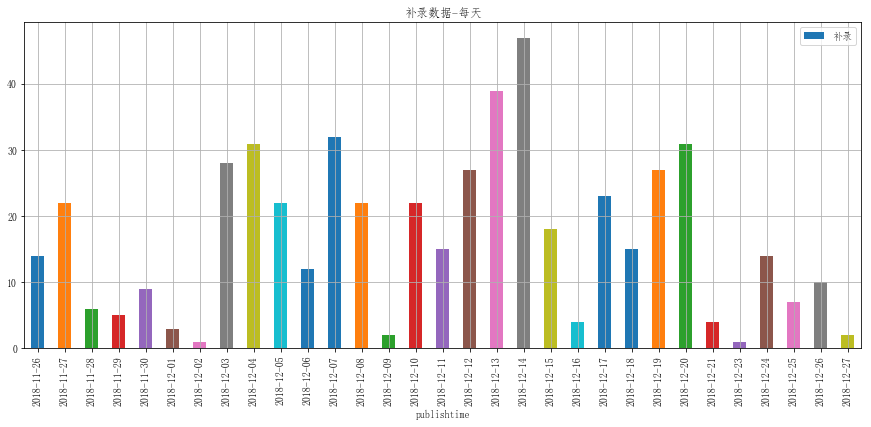

In [18]:
# 补录
apend = circ_cor_count[circ_cor_count['classify'] == '补录'][['publishtime', 'count']]
apend.columns = ['publishtime', '补录']
apend = apend.sort_values(by = 'publishtime', ascending = True)
apend.plot(kind = 'bar', x = 'publishtime', y = '补录', figsize=(15,6), 
           title = '补录数据-每天', grid = True)
apend.sort_values(by = 'publishtime', ascending = False).head()

### class

In [19]:
class_count = pd.concat([circ_cor_count, circ_uncor_count])
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2018-12-27   102.000  216.000  302.000 12509.000  402.000 1124.000  818.000   
2018-12-26   743.000 1520.000 1700.000 70805.000 2444.000 4614.000 1769.000   
2018-12-25  1424.000 1952.000 1767.000 82789.000 2430.000 4484.000 2181.000   
2018-12-24   836.000 3059.000 1768.000 83912.000 1559.000 5838.000 2061.000   
2018-12-23   430.000  626.000  456.000 44337.000 1181.000 2873.000  945.000   

                                    总量       非噪音 非噪音-比例 噪音-比例  
classify        补录     资本市场                                    
publishtime                                                    
2018-12-27   2.000 1438.000  16913.000  4404.000  0.260 0.740  
2018-12-26  10.000 5683.000  89288.000 18483.000  0.207 0.793  
2018-12-25   7.000 4874.000 101908.000 19119.000  0.188 0.812  
2018-12-24  14.000 6248.000 105295.000 21383.000  0.203 0.797  
2018-12-23   1.000 2207.000  53056.000  8719.000  0.164 0.836

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2018-12-27   102.000  216.000  302.000 12509.000  402.000 1124.000  818.000   
2018-12-26   743.000 1520.000 1700.000 70805.000 2444.000 4614.000 1769.000   
2018-12-25  1424.000 1952.000 1767.000 82789.000 2430.000 4484.000 2181.000   
2018-12-24   836.000 3059.000 1768.000 83912.000 1559.000 5838.000 2061.000   
2018-12-23   430.000  626.000  456.000 44337.000 1181.000 2873.000  945.000   

                                    总量  rate                                  \
classify        补录     资本市场             产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管   
publishtime                                                                    
2018-12-27   2.000 1438.000  16913.000 0.006  0.013  0.018 0.740 0.024 0.066   
2018-12-26  10.000 5683.000  89288.000 0.008  0.017  0.019 0.793 0.027 0.052   
2018-12-25   7.000 4874.000 101908.000 0.014  0.019  0.017 0.812 0.024 0.044   
2018-12-24  14.000 6248.000 105295.000 0.008  0.029  0.017 0.797 0.015 0.055   
2018-12-23   1.000 2207.000  53056.000 0.008  0.012  0.009 0.836 0.022 0.054   

                               
classify       行业    补录  资本市场  
publishtime                    
2018-12-27  0.048 0.000 0.085  
2018-12-26  0.020 0.000 0.064  
2018-12-25  0.021 0.000 0.048  
2018-12-24  0.020 0.000 0.059  
2018-12-23  0.018 0.000 0.042

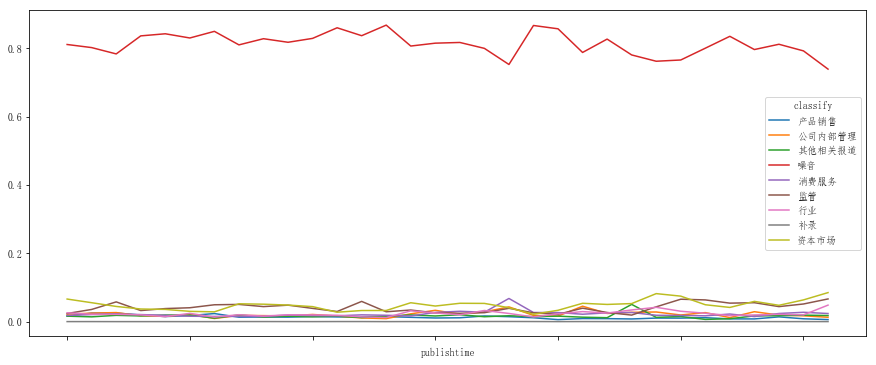

In [20]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

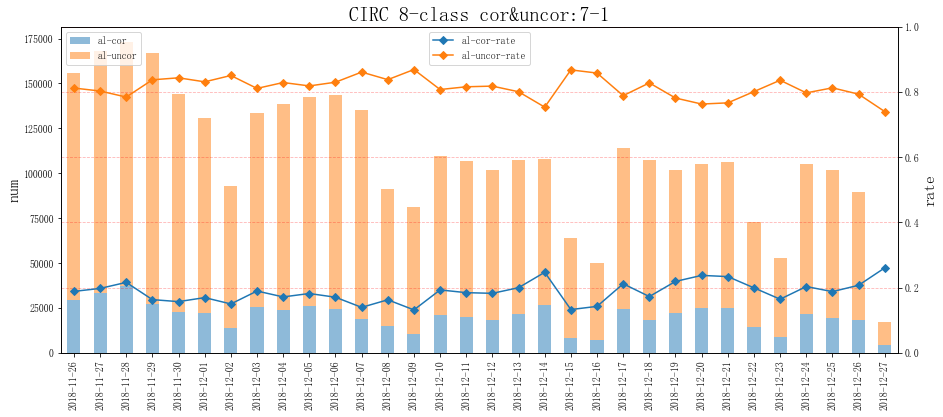

   publishtime        sum    al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2018-12-27  16913.000  4404.000 12509.000        0.260          0.740
30  2018-12-26  89288.000 18483.000 70805.000        0.207          0.793
29  2018-12-25 101908.000 19119.000 82789.000        0.188          0.812
28  2018-12-24 105295.000 21383.000 83912.000        0.203          0.797
27  2018-12-23  53056.000  8719.000 44337.000        0.164          0.836


In [21]:
plot_cor(count_data_7, circ_day_thing, "CIRC 8-class cor&uncor:7-1")

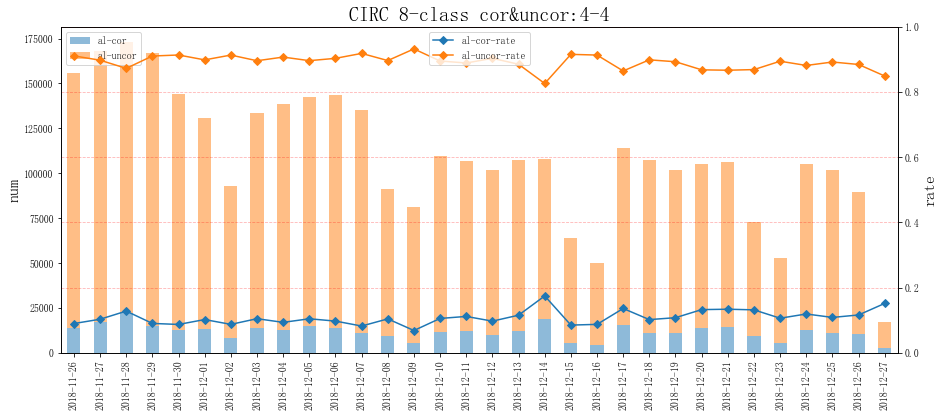

   publishtime  al_uncor        sum    al_cor  al_cor_rate  al_uncor_rate
31  2018-12-27 14351.000  16913.000  2562.000        0.151          0.849
30  2018-12-26 78931.000  89288.000 10357.000        0.116          0.884
29  2018-12-25 90854.000 101908.000 11054.000        0.108          0.892
28  2018-12-24 92764.000 105295.000 12531.000        0.119          0.881
27  2018-12-23 47430.000  53056.000  5626.000        0.106          0.894


In [22]:
plot_cor(count_data_4, circ_day_thing, "CIRC 8-class cor&uncor:4-4")

## 倾向性

In [23]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.tendency, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count.head()

,publishtime,tendency,count
0,2018-12-27,-1,543
1,2018-12-27,0,3868
2,2018-12-26,-1,3413
3,2018-12-26,0,15071
4,2018-12-25,-1,3037


In [24]:
tend_count[~tend_count['tendency'].isin([-1, 0])].head()

,publishtime,tendency,count
8,2018-12-24,1,4
17,2018-12-20,1,11
20,2018-12-19,1,10
25,2018-12-17,1,6
32,2018-12-14,1,6


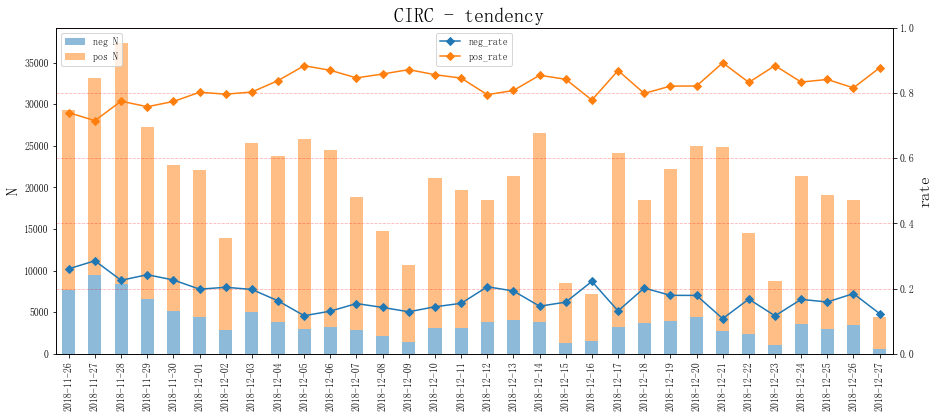

   publishtime   neg    pos    sum  neg_rate  pos_rate
31  2018-12-27   543   3868   4411     0.123     0.877
30  2018-12-26  3413  15071  18484     0.185     0.815
29  2018-12-25  3037  16082  19119     0.159     0.841
28  2018-12-24  3568  17811  21379     0.167     0.833
27  2018-12-23  1015   7704   8719     0.116     0.884


In [25]:
tend_count = tend_count[tend_count['tendency'].isin([-1, 0])]
plot_tend(tend_count, circ_day_thing, "CIRC - tendency ")

### group_id

In [26]:
# sql_tend_group = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
#                             t1.tendency, t1.group_id, count(t1.id) as cor_count \
#                             from wise_web_docinfo t1 \
#                                 where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
#                                       date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
#                                 group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency, t1.group_id \
#                                 order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

# tend_group_count = pd.read_sql(sql_tend_group, engine)
# tend_group_count['group_id'] = tend_group_count['group_id'].apply(lambda x: group_dict[str(x)])
# tend_group_count.head()

## 补录和预警

### 一周数据

In [27]:
# add_start_day = '2018-10-27'
# add_end_day = '2018-11-02'

add_start_day = (today - datetime.timedelta(days=8)).strftime("%Y-%m-%d")
add_end_day = (today - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
print('add_start_day：',add_start_day)
print('add_end_day：',add_end_day)

add_start_day： 2018-12-19
add_end_day： 2018-12-26


In [28]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(94, 7)


In [29]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format(add_start_day, add_end_day) 

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(57, 7)


In [30]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['submited'].replace(0, '不预警').replace(1, '预警')

去重前 (151, 7)
去重后 (138, 7)


In [31]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_i"
url = "http://47.93.77.19:10000/judge_correlation_i"
parse_data, elapsed_time = get_server_res(data, url)
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,12870560,行业,,1,1
1,12870565,行业,,1,1
2,12872862,行业,,1,1
3,12872863,噪音,,0,0
4,12872864,资本市场,,0,1


In [32]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [33]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [34]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_cor, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_w_cor, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat

来源,微信,新闻,新闻客户端,纸媒,论坛,总量
保监会：2018-12-19 到 2018-12-26,,,,,,
补录,6.000,76.000,7.000,4.000,1.000,94.000
预警数量,4.000,26.000,2.000,25.000,NaN,57.000
补录且预警,4.000,4.000,2.000,3.000,NaN,13.000
补录&过算法(7类),6.000,40.000,7.000,4.000,1.000,58.000
补录且预警&过算法(7类),4.000,4.000,2.000,3.000,NaN,13.000
补录且预警 / 预警-比例,100%,15%,100%,12%,nan%,23%
补录且预警 / 补录-比例,67%,5%,29%,75%,nan%,14%
补录&过算法(7类) / 补录-比例,100%,53%,100%,100%,100%,62%
补录且预警&过算法(7类) / 补录且预警-比例,100%,100%,100%,100%,nan%,100%


### 导出一段时间补录数据用于训练

In [35]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [36]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [37]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_i"
    url = "http://47.93.77.19:10000/judge_correlation_i"
    folder = 'circ_result_class'
    filename = 'circ_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'circ')

# 银行业--旧
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：

## 特殊时间点

In [38]:
engine = specific_func.get_engine('cbrc')

In [39]:
cbrc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

## 八分类

In [40]:
sql_cbrc = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
                        t2.traffic_id as classify, count(t1.id) as count \
                            from wise_web_docinfo_basic t1, wise_web_classify_traffic_docinfo t2 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t2.base_id=t1.id \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t2.traffic_id \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

cbrc_count = pd.read_sql(sql_cbrc, engine)
cbrc_count['classify'] = cbrc_count['classify'].apply(lambda x:class_name_dict[x])
cbrc_count.head()

,publishtime,classify,count
0,2018-12-27,监管,1748
1,2018-12-27,行业,4437
2,2018-12-27,产品销售,374
3,2018-12-27,资本市场,5696
4,2018-12-27,公司内部管理,509


### class

In [41]:
class_count = cbrc_count
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                      总量  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务     监管     行业   资本市场           
publishtime                                                                 
2018-12-27    374    509    896  17557  1434   1748   4437   5696   32651   
2018-12-26   2225   4683   4705  85760  9750   8958  14493  25627  156201   
2018-12-25   3391   4366   5608  97646  8380  11072  14988  28645  174096   
2018-12-24   2824   4119   5000  91786  8116  10436  16252  21538  160071   
2018-12-23   1209    811   2684  55562  4115   2844   6258   9832   83315   

               非噪音 非噪音-比例 噪音-比例  
classify                         
publishtime                      
2018-12-27   15094  0.462 0.538  
2018-12-26   70441  0.451 0.549  
2018-12-25   76450  0.439 0.561  
2018-12-24   68285  0.427 0.573  
2018-12-23   27753  0.333 0.667

count                                                      总量  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务     监管     行业   资本市场           
publishtime                                                                 
2018-12-27    374    509    896  17557  1434   1748   4437   5696   32651   
2018-12-26   2225   4683   4705  85760  9750   8958  14493  25627  156201   
2018-12-25   3391   4366   5608  97646  8380  11072  14988  28645  174096   
2018-12-24   2824   4119   5000  91786  8116  10436  16252  21538  160071   
2018-12-23   1209    811   2684  55562  4115   2844   6258   9832   83315   

             rate                                              
classify     产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                                    
2018-12-27  0.011  0.016  0.027 0.538 0.044 0.054 0.136 0.174  
2018-12-26  0.014  0.030  0.030 0.549 0.062 0.057 0.093 0.164  
2018-12-25  0.019  0.025  0.032 0.561 0.048 0.064 0.086 0.165  
2018-12-24  0.018  0.026  0.031 0.573 0.051 0.065 0.102 0.135  
2018-12-23  0.015  0.010  0.032 0.667 0.049 0.034 0.075 0.118

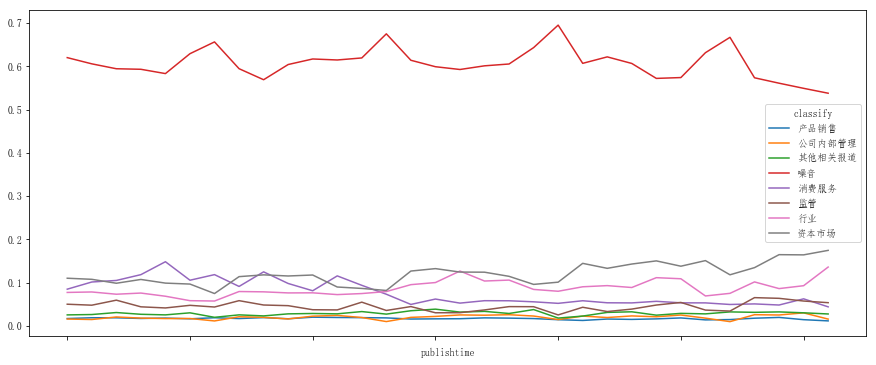

In [42]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

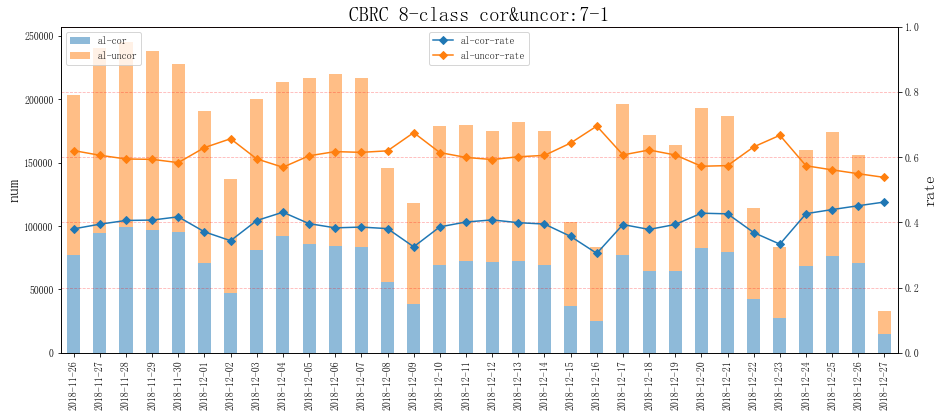

   publishtime     sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2018-12-27   32651   15094     17557        0.462          0.538
30  2018-12-26  156201   70441     85760        0.451          0.549
29  2018-12-25  174096   76450     97646        0.439          0.561
28  2018-12-24  160071   68285     91786        0.427          0.573
27  2018-12-23   83315   27753     55562        0.333          0.667


In [43]:
plot_cor(count_data_7, cbrc_day_thing, "CBRC 8-class cor&uncor:7-1")

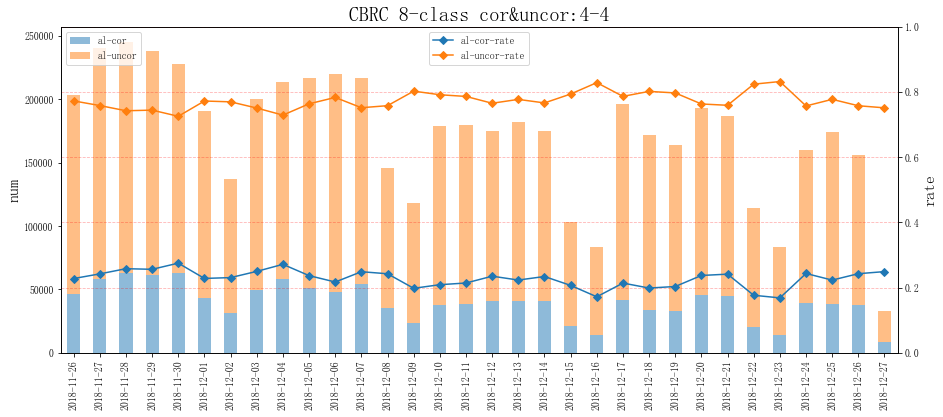

   publishtime  al_uncor     sum  al_cor  al_cor_rate  al_uncor_rate
31  2018-12-27     24523   32651    8128        0.249          0.751
30  2018-12-26    118317  156201   37884        0.243          0.757
29  2018-12-25    135290  174096   38806        0.223          0.777
28  2018-12-24    121148  160071   38923        0.243          0.757
27  2018-12-23     69287   83315   14028        0.168          0.832


In [44]:
plot_cor(count_data_4, cbrc_day_thing, "CBRC 8-class cor&uncor:4-4")

## 倾向性

In [45]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.sen as tendency, count(t1.id) as cor_count \
                            from elint_web_docinfo t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.sen \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count = tend_count[tend_count['tendency'] != 1]
tend_count.head()

,publishtime,tendency,cor_count
0,2018-12-27,-1,1073
1,2018-12-27,0,7315
3,2018-12-26,-1,9535
4,2018-12-26,0,29366
6,2018-12-25,-1,10759


In [46]:
tend_count[tend_count['tendency'].isin([-1, 0])].head()

,publishtime,tendency,cor_count
0,2018-12-27,-1,1073
1,2018-12-27,0,7315
3,2018-12-26,-1,9535
4,2018-12-26,0,29366
6,2018-12-25,-1,10759


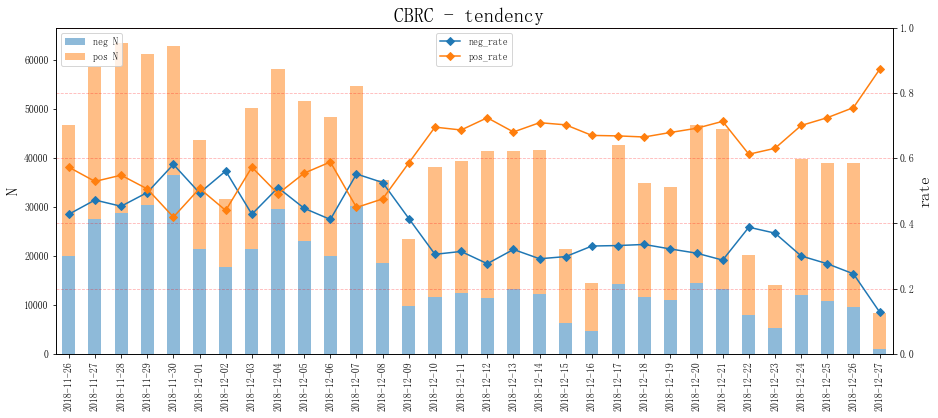

   publishtime    neg    pos    sum  neg_rate  pos_rate
31  2018-12-27   1073   7315   8388     0.128     0.872
30  2018-12-26   9535  29366  38901     0.245     0.755
29  2018-12-25  10759  28214  38973     0.276     0.724
28  2018-12-24  11890  27742  39632     0.300     0.700
27  2018-12-23   5195   8847  14042     0.370     0.630


In [47]:
tend_count = tend_count[tend_count['tendency'].isin([-1, 0])]
plot_tend(tend_count, cbrc_day_thing, "CBRC - tendency ")

## 补录和预警

### 补录数据

In [48]:
sql_human_additional = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, count(t1.id) as count \
                            from elint_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.gather_type = 1 \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

human_additional_count = pd.read_sql(sql_human_additional, engine)
human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

,publishtime,gather_type,count
0,2018-12-26,1,59
1,2018-12-25,1,67
2,2018-12-24,1,64
3,2018-12-23,1,14
4,2018-12-22,1,14


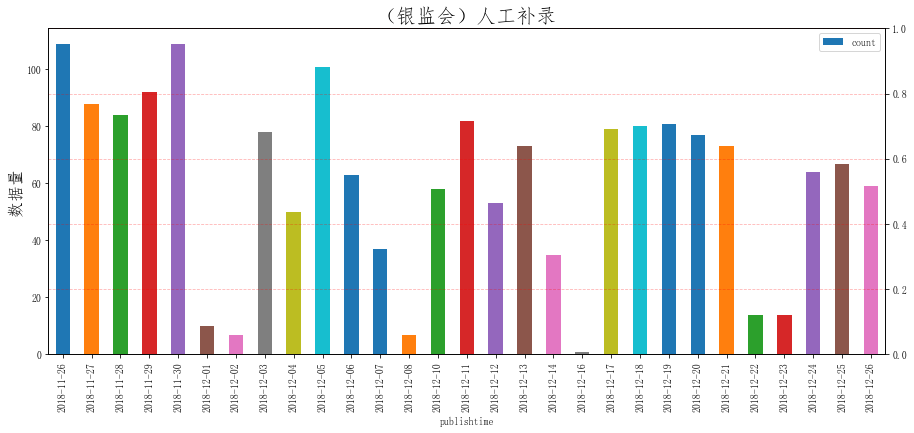

,publishtime,gather_type,count
0,2018-12-26,1,59
1,2018-12-25,1,67
2,2018-12-24,1,64
3,2018-12-23,1,14
4,2018-12-22,1,14


In [49]:
human_additional_count = human_additional_count.sort_values(by = 'publishtime')
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
human_additional_count.plot(x = 'publishtime', y = 'count', kind = 'bar', figsize = (15, 6), ax = ax1)
ax1.set_ylabel('数据量', fontsize = 16)
ax1.set_title("（银监会）人工补录", fontsize = 20)

ax2 = ax1.twinx()  # this is the important function
ax2.set_ylim(0, 1)
y_list = [0.65, 0.75, 0.85, 0.95]
m = 0
for [d, t] in cbrc_day_thing:    
    if d in human_additional_count['publishtime'].tolist():
        x = human_additional_count['publishtime'].tolist().index(d)
        ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                    color='k', linestyle = "--", alpha = 0.75)
        ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
        if m == 3: 
            m = 0
        else :
            m += 1
        
plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
plt.show()

human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

### 一周数据

In [50]:
# add_start_day = '2018-10-27'
# add_end_day = '2018-11-02'

add_start_day = (today - datetime.timedelta(days=8)).strftime("%Y-%m-%d")
add_end_day = (today - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
print('add_start_day：',add_start_day)
print('add_end_day：',add_end_day)

add_start_day： 2018-12-19
add_end_day： 2018-12-26


In [51]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(449, 7)


In [52]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format(add_start_day, add_end_day)  

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(845, 7)


In [53]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(0, '系统采集').replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['sec'].apply(lambda x: '预警' if x in [7,8,9] else '不预警')
# combined_data.head()

去重前 (1294, 7)
去重后 (854, 7)


In [54]:
combined_data.groupby(['gather_type', 'group_id', 'submited'])['id'].count()

gather_type  group_id  submited
4            微博        预警          201
人工修改         博客        预警            1
             外媒        预警            3
             微博        预警            8
             新闻        预警          105
             纸媒        预警           78
             论坛        预警            9
人工补录         微信        预警            3
             微博        预警          406
             新闻        不预警           9
                       预警           25
             纸媒        预警            6
Name: id, dtype: int64

In [55]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_yjh"
url = "http://47.93.77.19:6001/judge_correlation_yjh"
parse_data = get_server_res_yjh(data, url, 'sec')
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,273209469,行业,,1,1
1,273212646,公司内部管理,,0,1
2,273213983,噪音,,0,0
3,273213984,监管,,1,1
4,273213985,噪音,,0,0


In [56]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [57]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [58]:
stat

,group_id,gather_type,submited,id
0,博客,人工修改,预警,1
1,外媒,人工修改,预警,3
2,微信,人工补录,预警,3
3,微博,4,预警,201
4,微博,人工修改,预警,8
5,微博,人工补录,预警,406
6,新闻,人工修改,预警,105
7,新闻,人工补录,不预警,9
8,新闻,人工补录,预警,25
9,纸媒,人工修改,预警,78


In [59]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor, on = '来源')
stat = pd.merge(stat, stat_a_w_cor, on = '来源')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat = stat.fillna(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
# stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
# stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat.fillna(0)

来源,微信,微博,新闻,纸媒,总量
保监会：2018-12-19 到 2018-12-26,,,,,
补录,3.000,406.000,34.000,6.000,449.000
预警数量,3.000,615.000,130.000,84.000,832.000
补录且预警,3.000,406.000,25.000,6.000,440.000
补录&过算法(4类),3.000,406.000,12.000,6.000,427.000
补录且预警&过算法(4类),3.000,406.000,10.000,6.000,425.000
补录&过算法(7类),3.000,406.000,28.000,6.000,443.000
补录且预警&过算法(7类),3.000,406.000,24.000,6.000,439.000
补录且预警 / 预警-比例,100%,66%,19%,7%,53%
补录&过算法(4类) / 补录-比例,100%,100%,35%,100%,95%


### 导出一段时间补录数据用于训练

In [60]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [61]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [62]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_yjh"
    url = "http://47.93.77.19:6001/judge_correlation_yjh"
    folder = 'cbrc_result_class'
    filename = 'cbrc_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'cbrc')

# 安徽银监局
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：

## 特殊时间点

In [63]:
engine = specific_func.get_engine('ahyjj')

In [64]:
cbirc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

In [65]:
start_day = today - datetime.timedelta(days=32) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

# day_select = '2018-09-09'
day_list = get_day_list(start_day, end_day)
print(day_list)
len(day_list)

start_day： 2018-11-25
end_day： 2018-12-26
['2018-11-26', '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30', '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04', '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08', '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14', '2018-12-15', '2018-12-16', '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25', '2018-12-26']


31

## 获取数据

In [66]:
for t in range(6, 7):
    print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            print('   已存在：', filename)
        else :
            t0 = time.time()
            sql_cbirc = '''
            SELECT
                t2.type,
                t1.traffic_id AS classify,
                t2.sen as tendency, 
                COUNT(t1.id) AS count,
                t2.gather_type,
                t3.group_id,
                t2.sec
            FROM
                db_classify_traffic_docinfo t1
                    LEFT JOIN
                db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
                    LEFT JOIN
                db_docinfo t3 ON t2.urlhash = t3.urlhash
            WHERE
                t3.publishtime >= '{0} 00:00:00'
                AND t3.publishtime <= '{0} 23:59:59'
                    and t2.type = {1}
                    and t1.type = t2.type
            GROUP BY t2.gather_type, t2.type , t1.traffic_id, t3.group_id, t2.sen, t2.sec
            '''.format(day, 1)

            cbirc_count_type = pd.read_sql(sql_cbirc, engine)     
            cbirc_count_type['publishtime'] = day
            cbirc_count_type.to_excel(filename, index = False)    
            print('   日期：%s ；耗时：%s s'%(day, time.time() - t0))
            print('   已生成：', filename)

获取 安徽银监局 的数据 -------
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-26_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-27_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-28_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-29_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-30_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-01_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-02_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-03_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-04_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-05_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-12-06_mysql

In [67]:
cbirc_count_all = pd.DataFrame()
for t in range(6, 7):
#     print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            cbirc_count_type = pd.read_excel(filename)
            cbirc_count_all = pd.concat([cbirc_count_all, cbirc_count_type], axis = 0)
        else :
            print('   不存在：', filename)

In [68]:
# cbirc_count_all.rename(columns={'publistime': 'publishtime'}, inplace=True) 
print(cbirc_count_all.shape)
cbirc_count_all.head()

(1506, 8)


,type,classify,tendency,count,gather_type,group_id,sec,publishtime
0,1,1,-1,6,0,1,4,2018-11-26
1,1,1,-1,1,0,1,7,2018-11-26
2,1,1,0,6,0,1,4,2018-11-26
3,1,1,0,1,0,5,4,2018-11-26
4,1,1,-1,25,0,11,4,2018-11-26


### 八分类数据

In [69]:
cbirc_count = cbirc_count_all.groupby(['publishtime', 'type', 'classify'])['count'].sum()
cbirc_count = cbirc_count.reset_index(['publishtime', 'type', 'classify'])
cbirc_count.head()

,publishtime,type,classify,count
0,2018-11-26,1,1,120
1,2018-11-26,1,2,430
2,2018-11-26,1,3,48
3,2018-11-26,1,4,493
4,2018-11-26,1,5,131


In [70]:
cbirc_count['classify'] = cbirc_count['classify'].apply(lambda x:class_name_dict[int(x)])
cbirc_count['type'] = cbirc_count['type'].apply(lambda x:proj_name_dict[int(6)])
print(cbirc_count.shape)
print(cbirc_count.info(memory_usage = 'deep'))
# cbirc_count.head()

print(cbirc_count['count'].sum())
cbirc_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(246, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 4 columns):
publishtime    246 non-null object
type           246 non-null object
classify       246 non-null object
count          246 non-null int64
dtypes: int64(1), object(3)
memory usage: 64.6 KB
None
39745


sum       
             count       
type         安徽银监局    All
publishtime              
2018-11-26    3929   3929
2018-11-27    3853   3853
2018-11-28    2232   2232
2018-11-29    2045   2045
2018-11-30    1933   1933
2018-12-01    1014   1014
2018-12-02    1102   1102
2018-12-03    2335   2335
2018-12-04    2149   2149
2018-12-05    1421   1421
2018-12-06    2210   2210
2018-12-07    2774   2774
2018-12-08    1225   1225
2018-12-09     896    896
2018-12-10    1154   1154
2018-12-11    1448   1448
2018-12-12     980    980
2018-12-13     682    682
2018-12-14     618    618
2018-12-15     254    254
2018-12-16     275    275
2018-12-17    1112   1112
2018-12-18     554    554
2018-12-19     456    456
2018-12-20     671    671
2018-12-21     525    525
2018-12-22     139    139
2018-12-23      60     60
2018-12-24     318    318
2018-12-25     733    733
2018-12-26     648    648
All          39745  39745

### 倾向性数据

In [71]:
tend_count = cbirc_count_all.groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count = tend_count.reset_index(['publishtime', 'type', 'tendency'])
tend_count.head()

,publishtime,type,tendency,count
0,2018-11-26,1,-1,180
1,2018-11-26,1,0,3749
2,2018-11-27,1,-1,116
3,2018-11-27,1,0,3737
4,2018-11-28,1,-1,130


In [72]:
# cor_list = ['产品销售', '资本市场', '其他相关报道', '噪音'] # 3、4、7、8
cor_list = [3,4,7,8]
tend_count_4 = cbirc_count_all[~cbirc_count_all['classify'].isin(cor_list)].groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count_4 = tend_count_4.reset_index(['publishtime', 'type', 'tendency'])
tend_count_4['type'] = tend_count_4['type'].apply(lambda x:proj_name_dict[int(6)])
tend_count_4.head()

,publishtime,type,tendency,count
0,2018-11-26,安徽银监局,-1,180
1,2018-11-26,安徽银监局,0,625
2,2018-11-27,安徽银监局,-1,116
3,2018-11-27,安徽银监局,0,886
4,2018-11-28,安徽银监局,-1,130


In [73]:
tend_count['type'] = tend_count['type'].apply(lambda x:proj_name_dict[int(6)])
print(tend_count.shape)
print(tend_count.info(memory_usage = 'deep'))
# tend_count.head()

print(tend_count['count'].sum())
tend_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(62, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 4 columns):
publishtime    62 non-null object
type           62 non-null object
tendency       62 non-null int64
count          62 non-null int64
dtypes: int64(2), object(2)
memory usage: 11.6 KB
None
39745


sum       
             count       
type         安徽银监局    All
publishtime              
2018-11-26    3929   3929
2018-11-27    3853   3853
2018-11-28    2232   2232
2018-11-29    2045   2045
2018-11-30    1933   1933
2018-12-01    1014   1014
2018-12-02    1102   1102
2018-12-03    2335   2335
2018-12-04    2149   2149
2018-12-05    1421   1421
2018-12-06    2210   2210
2018-12-07    2774   2774
2018-12-08    1225   1225
2018-12-09     896    896
2018-12-10    1154   1154
2018-12-11    1448   1448
2018-12-12     980    980
2018-12-13     682    682
2018-12-14     618    618
2018-12-15     254    254
2018-12-16     275    275
2018-12-17    1112   1112
2018-12-18     554    554
2018-12-19     456    456
2018-12-20     671    671
2018-12-21     525    525
2018-12-22     139    139
2018-12-23      60     60
2018-12-24     318    318
2018-12-25     733    733
2018-12-26     648    648
All          39745  39745

### 预警与补录数据

In [74]:
cbirc_add = cbirc_count_all.groupby(['publishtime', 'type', 'gather_type'])['count'].sum()
cbirc_add = cbirc_add.reset_index(['publishtime', 'type', 'gather_type'])
cbirc_add = cbirc_add[cbirc_add['gather_type'].isin([1,3])]
cbirc_add.head()

,publishtime,type,gather_type,count


In [75]:
# # cbirc_add['gather_type'] = cbirc_add['gather_type'].apply(lambda x:group_dict[str(x)])
# cbirc_add['type'] = cbirc_add['type'].apply(lambda x:proj_name_dict[int(6)])
# print(cbirc_add.shape)
# print(cbirc_add.info(memory_usage = 'deep'))
# # cbirc_count.head()

# print(cbirc_add['count'].sum())
# cbirc_add.pivot_table(index = ['publishtime'], columns = ['type', 'gather_type'], 
#                         aggfunc = [np.sum], values = ['count'], 
#                         fill_value = 0, margins = True)

## 八分类

In [76]:
class_count = cbirc_count[cbirc_count['type'] == '安徽银监局'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                          总量  \
classify     产品销售  公司内部管理 其他相关报道     噪音   消费服务     监管      行业    资本市场           
publishtime                                                                     
2018-12-26  3.000 222.000 32.000 50.000 42.000 17.000 260.000  22.000 648.000   
2018-12-25  9.000 138.000 30.000 41.000 60.000 53.000 273.000 129.000 733.000   
2018-12-24  5.000  59.000 25.000 44.000 32.000 10.000  95.000  48.000 318.000   
2018-12-23  6.000   9.000  1.000  5.000  6.000  2.000  24.000   7.000  60.000   
2018-12-22    nan  34.000  1.000 17.000 36.000  5.000  37.000   9.000 139.000   

                非噪音 非噪音-比例 噪音-比例  
classify                          
publishtime                       
2018-12-26  598.000  0.923 0.077  
2018-12-25  692.000  0.944 0.056  
2018-12-24  274.000  0.862 0.138  
2018-12-23   55.000  0.917 0.083  
2018-12-22  122.000  0.878 0.122

count                                                          总量  \
classify     产品销售  公司内部管理 其他相关报道     噪音   消费服务     监管      行业    资本市场           
publishtime                                                                     
2018-12-26  3.000 222.000 32.000 50.000 42.000 17.000 260.000  22.000 648.000   
2018-12-25  9.000 138.000 30.000 41.000 60.000 53.000 273.000 129.000 733.000   
2018-12-24  5.000  59.000 25.000 44.000 32.000 10.000  95.000  48.000 318.000   
2018-12-23  6.000   9.000  1.000  5.000  6.000  2.000  24.000   7.000  60.000   
2018-12-22    nan  34.000  1.000 17.000 36.000  5.000  37.000   9.000 139.000   

             rate                                              
classify     产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                                    
2018-12-26  0.005  0.343  0.049 0.077 0.065 0.026 0.401 0.034  
2018-12-25  0.012  0.188  0.041 0.056 0.082 0.072 0.372 0.176  
2018-12-24  0.016  0.186  0.079 0.138 0.101 0.031 0.299 0.151  
2018-12-23  0.100  0.150  0.017 0.083 0.100 0.033 0.400 0.117  
2018-12-22    nan  0.245  0.007 0.122 0.259 0.036 0.266 0.065

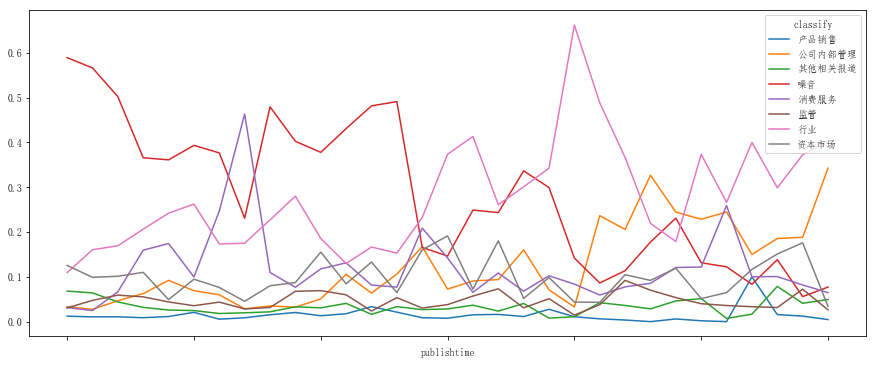

In [77]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

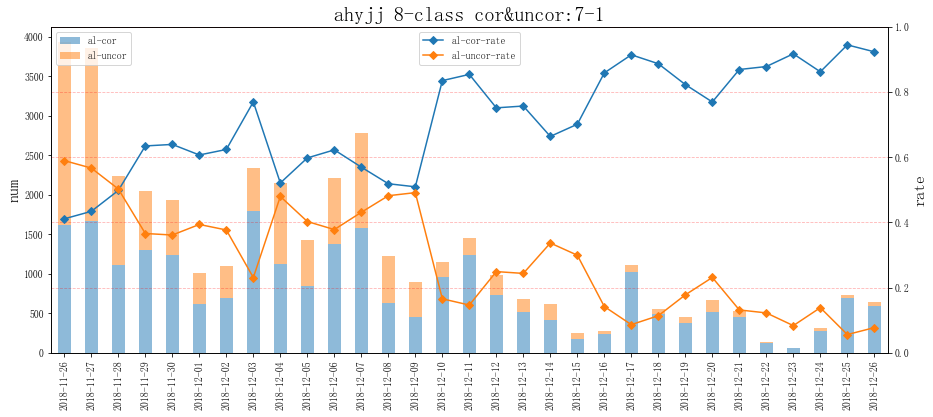

   publishtime     sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
30  2018-12-26 648.000 598.000    50.000        0.923          0.077
29  2018-12-25 733.000 692.000    41.000        0.944          0.056
28  2018-12-24 318.000 274.000    44.000        0.862          0.138
27  2018-12-23  60.000  55.000     5.000        0.917          0.083
26  2018-12-22 139.000 122.000    17.000        0.878          0.122


In [78]:
plot_cor(count_data_7, cbirc_day_thing, "ahyjj 8-class cor&uncor:7-1")

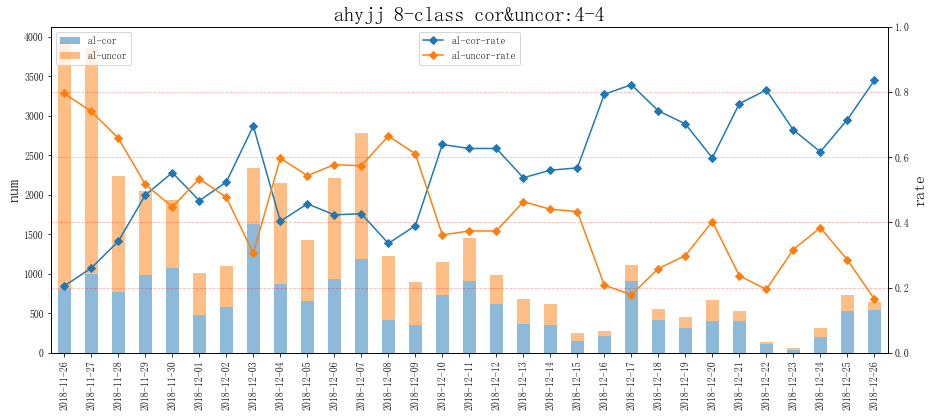

   publishtime  al_uncor     sum  al_cor  al_cor_rate  al_uncor_rate
30  2018-12-26   107.000 648.000 541.000        0.835          0.165
29  2018-12-25   209.000 733.000 524.000        0.715          0.285
28  2018-12-24   122.000 318.000 196.000        0.616          0.384
27  2018-12-23    19.000  60.000  41.000        0.683          0.317
26  2018-12-22    27.000 139.000 112.000        0.806          0.194


In [79]:
plot_cor(count_data_4, cbirc_day_thing, "ahyjj 8-class cor&uncor:4-4")

## 倾向性

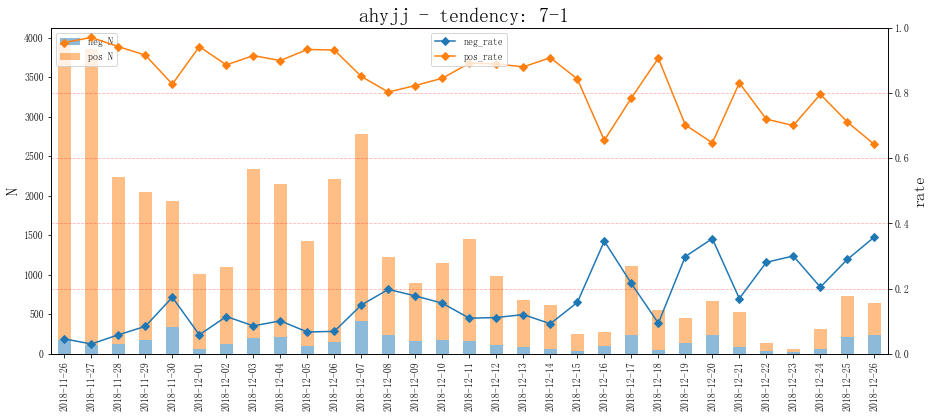

   publishtime  neg  pos  sum  neg_rate  pos_rate
30  2018-12-26  232  416  648     0.358     0.642
29  2018-12-25  212  521  733     0.289     0.711
28  2018-12-24   65  253  318     0.204     0.796
27  2018-12-23   18   42   60     0.300     0.700
26  2018-12-22   39  100  139     0.281     0.719


In [80]:
plot_tend(tend_count[tend_count['type'] == '安徽银监局'].drop('type', axis = 1), cbirc_day_thing, "ahyjj - tendency: 7-1 ")

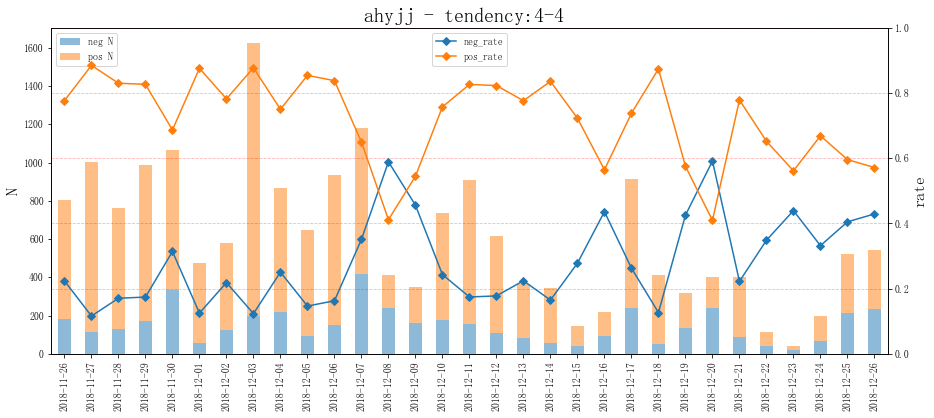

   publishtime  neg  pos  sum  neg_rate  pos_rate
30  2018-12-26  232  309  541     0.429     0.571
29  2018-12-25  212  312  524     0.405     0.595
28  2018-12-24   65  131  196     0.332     0.668
27  2018-12-23   18   23   41     0.439     0.561
26  2018-12-22   39   73  112     0.348     0.652


In [81]:
plot_tend(tend_count_4[tend_count_4['type'] == '安徽银监局'].drop('type', axis = 1), cbirc_day_thing, "ahyjj - tendency:4-4 ")

## 补录

In [82]:
# plot_add(cbirc_add[cbirc_add['type'] == '安徽银监局'], cbirc_day_thing, "（安徽银监局）人工补录")

# 银保监会--新

## 特殊时间点

In [83]:
engine = specific_func.get_engine('cbirc')

In [84]:
cbirc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

In [85]:
start_day = today - datetime.timedelta(days=30) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

# day_select = '2018-09-09'
day_list = get_day_list(start_day, end_day)
print(day_list)

start_day： 2018-11-27
end_day： 2018-12-26
['2018-11-28', '2018-11-29', '2018-11-30', '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04', '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08', '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14', '2018-12-15', '2018-12-16', '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25', '2018-12-26']


## 获取数据

In [86]:
for t in range(1, 6):
    print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            print('   已存在：', filename)
        else :
            t0 = time.time()
            sql_cbirc = '''
            SELECT
                t2.type,
                t1.traffic_id AS classify,
                t2.sen as tendency, 
                COUNT(t1.id) AS count,
                t2.gather_type,
                t3.group_id,
                t2.sec
            FROM
                cbrc_circ.db_classify_traffic_docinfo t1
                    LEFT JOIN
                cbrc_circ.db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
                    LEFT JOIN
                cbrc_circ.db_docinfo t3 ON t2.urlhash = t3.urlhash
            WHERE
                t3.publishtime >= '{0} 00:00:00'
                AND t3.publishtime <= '{0} 23:59:59'
                    and t2.type = {1}
                    and t1.type = t2.type
            GROUP BY t2.gather_type, t2.type , t1.traffic_id, t3.group_id, t2.sen, t2.sec
            '''.format(day, t)

            cbirc_count_type = pd.read_sql(sql_cbirc, engine)     
            cbirc_count_type['publishtime'] = day
            cbirc_count_type.to_excel(filename, index = False)    
            print('   日期：%s ；耗时：%s s'%(day, time.time() - t0))
            print('   已生成：', filename)

获取 银监会 的数据 -------
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-11-28_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-11-29_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-11-30_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-12-01_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-12-02_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-12-03_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-12-04_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-12-05_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-12-06_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-12-07_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-12-08_mysql_stat.xlsx
   已存在： stati

   日期：2018-12-24 ；耗时：66.81182146072388 s
   已生成： statistics_result/mysql_daily_count_by_condition/建行北分_2018-12-24_mysql_stat.xlsx
   日期：2018-12-25 ；耗时：61.29050540924072 s
   已生成： statistics_result/mysql_daily_count_by_condition/建行北分_2018-12-25_mysql_stat.xlsx
   日期：2018-12-26 ；耗时：51.800962924957275 s
   已生成： statistics_result/mysql_daily_count_by_condition/建行北分_2018-12-26_mysql_stat.xlsx
获取 中国人保 的数据 -------
   已存在： statistics_result/mysql_daily_count_by_condition/中国人保_2018-11-28_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/中国人保_2018-11-29_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/中国人保_2018-11-30_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/中国人保_2018-12-01_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/中国人保_2018-12-02_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/中国人保_2018-12-03_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_conditio

In [87]:
cbirc_count_all = pd.DataFrame()
for t in range(1, 6):
    print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            cbirc_count_type = pd.read_excel(filename)
            cbirc_count_all = pd.concat([cbirc_count_all, cbirc_count_type], axis = 0)
        else :
            print('   不存在：', filename)

获取 银监会 的数据 -------
获取 保监会 的数据 -------
获取 中国人寿 的数据 -------
获取 建行北分 的数据 -------
获取 中国人保 的数据 -------


In [88]:
print(cbirc_count_all.shape)
cbirc_count_all.head()

(10293, 8)


,type,classify,tendency,count,gather_type,group_id,sec,publishtime
0,1,1,-1,199,0,1,4,2018-11-28
1,1,1,0,3280,0,1,4,2018-11-28
2,1,1,0,4,0,2,4,2018-11-28
3,1,1,-1,1,0,3,4,2018-11-28
4,1,1,0,9,0,3,4,2018-11-28


### 八分类数据

In [89]:
cbirc_count = cbirc_count_all.groupby(['publishtime', 'type', 'classify'])['count'].sum()
cbirc_count = cbirc_count.reset_index(['publishtime', 'type', 'classify'])
cbirc_count.head()

,publishtime,type,classify,count
0,2018-11-28,1,1,4736
1,2018-11-28,1,2,3193
2,2018-11-28,1,3,2319
3,2018-11-28,1,4,7195
4,2018-11-28,1,5,3788


In [90]:
cbirc_count['classify'] = cbirc_count['classify'].apply(lambda x:class_name_dict[int(x)])
cbirc_count['type'] = cbirc_count['type'].apply(lambda x:proj_name_dict[int(x)])
print(cbirc_count.shape)
print(cbirc_count.info(memory_usage = 'deep'))
# cbirc_count.head()

print(cbirc_count['count'].sum())
cbirc_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(1218, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 4 columns):
publishtime    1218 non-null object
type           1218 non-null object
classify       1218 non-null object
count          1218 non-null int64
dtypes: int64(1), object(3)
memory usage: 315.6 KB
None
3937810


sum                                           
              count                                           
type           中国人保    中国人寿      保监会    建行北分      银监会      All
publishtime                                                   
2018-11-28    16226    8352    90513   11223    89244   215558
2018-11-29    13514    7322    82200    7340    91323   201699
2018-11-30    14463    5959    68146    6134    76514   171216
2018-12-01    17386    5140    66171    1818    59985   150500
2018-12-02    11122    3442    46103    1003    40556   102226
2018-12-03     9997    5503    64910    1647    67049   149106
2018-12-04    12800    4840    66397    3008    70891   157936
2018-12-05    15651    5009    69653    1935    71467   163715
2018-12-06    14982    5255    69435    1650    74562   165884
2018-12-07    11796    3588    69972    2269    77952   165577
2018-12-08    13551    2113    42334    2489    45733   106220
2018-12-09    14927    1467    39247    1362    41982    98985
2018-12-10    23613    3067    52152    2523    67444   148799
2018-12-11    18922    3400    55011    1992    67409   146734
2018-12-12    13141    4664    57687    2032    73695   151219
2018-12-13    13861    5879    64195    2269    76649   162853
2018-12-14    15740    5233    63198    4782    70519   159472
2018-12-15    12144    1067    30775    2990    36086    83062
2018-12-16    15201     674    24445    1496    24706    66522
2018-12-17    15739    2677    57540    5673    57034   138663
2018-12-18    13408    3093    49150    3193    57036   125880
2018-12-19    11326    2845    40910    6911    43122   105114
2018-12-20    10481    4005    51211   13537    59536   138770
2018-12-21    10732    3052    50405   12106    57369   133664
2018-12-22     8647    1509    33938    4882    36865    85841
2018-12-23     8397     726    24840    3723    21017    58703
2018-12-24    12556    3661    54001    7967    57920   136105
2018-12-25     9817    2415    49821    7569    54508   124130
2018-12-26    12093    1914    45410    6308    57932   123657
All          392233  107871  1579770  131831  1726105  3937810

### 倾向性数据

In [91]:
tend_count = cbirc_count_all.groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count = tend_count.reset_index(['publishtime', 'type', 'tendency'])
tend_count.head()

,publishtime,type,tendency,count
0,2018-11-28,1,-1,2831
1,2018-11-28,1,0,86413
2,2018-11-28,2,-1,3736
3,2018-11-28,2,0,86777
4,2018-11-28,3,-1,778


In [92]:
# cor_list = ['产品销售', '资本市场', '其他相关报道', '噪音'] # 3、4、7、8
cor_list = [3,4,7,8]
tend_count_4 = cbirc_count_all[~cbirc_count_all['classify'].isin(cor_list)].groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count_4 = tend_count_4.reset_index(['publishtime', 'type', 'tendency'])
tend_count_4['type'] = tend_count_4['type'].apply(lambda x:proj_name_dict[int(x)])
tend_count_4.head()

,publishtime,type,tendency,count
0,2018-11-28,银监会,-1,2831
1,2018-11-28,银监会,0,11184
2,2018-11-28,保监会,-1,3736
3,2018-11-28,保监会,0,10183
4,2018-11-28,中国人寿,-1,606


In [93]:
tend_count['type'] = tend_count['type'].apply(lambda x:proj_name_dict[int(x)])
print(tend_count.shape)
print(tend_count.info(memory_usage = 'deep'))
# tend_count.head()

print(tend_count['count'].sum())
tend_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(291, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 4 columns):
publishtime    291 non-null object
type           291 non-null object
tendency       291 non-null int64
count          291 non-null int64
dtypes: int64(2), object(2)
memory usage: 52.4 KB
None
3937810


sum                                           
              count                                           
type           中国人保    中国人寿      保监会    建行北分      银监会      All
publishtime                                                   
2018-11-28    16226    8352    90513   11223    89244   215558
2018-11-29    13514    7322    82200    7340    91323   201699
2018-11-30    14463    5959    68146    6134    76514   171216
2018-12-01    17386    5140    66171    1818    59985   150500
2018-12-02    11122    3442    46103    1003    40556   102226
2018-12-03     9997    5503    64910    1647    67049   149106
2018-12-04    12800    4840    66397    3008    70891   157936
2018-12-05    15651    5009    69653    1935    71467   163715
2018-12-06    14982    5255    69435    1650    74562   165884
2018-12-07    11796    3588    69972    2269    77952   165577
2018-12-08    13551    2113    42334    2489    45733   106220
2018-12-09    14927    1467    39247    1362    41982    98985
2018-12-10    23613    3067    52152    2523    67444   148799
2018-12-11    18922    3400    55011    1992    67409   146734
2018-12-12    13141    4664    57687    2032    73695   151219
2018-12-13    13861    5879    64195    2269    76649   162853
2018-12-14    15740    5233    63198    4782    70519   159472
2018-12-15    12144    1067    30775    2990    36086    83062
2018-12-16    15201     674    24445    1496    24706    66522
2018-12-17    15739    2677    57540    5673    57034   138663
2018-12-18    13408    3093    49150    3193    57036   125880
2018-12-19    11326    2845    40910    6911    43122   105114
2018-12-20    10481    4005    51211   13537    59536   138770
2018-12-21    10732    3052    50405   12106    57369   133664
2018-12-22     8647    1509    33938    4882    36865    85841
2018-12-23     8397     726    24840    3723    21017    58703
2018-12-24    12556    3661    54001    7967    57920   136105
2018-12-25     9817    2415    49821    7569    54508   124130
2018-12-26    12093    1914    45410    6308    57932   123657
All          392233  107871  1579770  131831  1726105  3937810

### 补录数据

In [94]:
cbirc_add = cbirc_count_all.groupby(['publishtime', 'type', 'gather_type'])['count'].sum()
cbirc_add = cbirc_add.reset_index(['publishtime', 'type', 'gather_type'])
cbirc_add = cbirc_add[cbirc_add['gather_type'].isin([1,3])]
cbirc_add.head()

,publishtime,type,gather_type,count
5,2018-11-28,4,3,12
7,2018-11-28,5,1,6
14,2018-11-29,4,3,7
16,2018-11-29,5,1,9
21,2018-11-30,3,1,1


In [95]:
# cbirc_add['gather_type'] = cbirc_add['gather_type'].apply(lambda x:group_dict[str(x)])
cbirc_add['type'] = cbirc_add['type'].apply(lambda x:proj_name_dict[int(x)])
print(cbirc_add.shape)
print(cbirc_add.info(memory_usage = 'deep'))
# cbirc_count.head()

print(cbirc_add['count'].sum())
cbirc_add.pivot_table(index = ['publishtime'], columns = ['type', 'gather_type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(64, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 5 to 251
Data columns (total 4 columns):
publishtime    64 non-null object
type           64 non-null object
gather_type    64 non-null int64
count          64 non-null int64
dtypes: int64(2), object(2)
memory usage: 12.1 KB
None
352


sum                   
            count                   
type         中国人保 中国人寿 建行北分      All
gather_type     1    1    1   3     
publishtime                         
2018-11-28      6    0    0  12   18
2018-11-29      9    0    0   7   16
2018-11-30     13    1    0  44   58
2018-12-01      4    1    2   0    7
2018-12-02      3    2    0   0    5
2018-12-03     11   10   22   0   43
2018-12-04      4   13    7   0   24
2018-12-05      6   11    9   0   26
2018-12-06      1    4    8   0   13
2018-12-07      2    4    7   0   13
2018-12-08      0    0    2   0    2
2018-12-09      1    0    1   0    2
2018-12-10      6    3    3   0   12
2018-12-11      2   10    2   0   14
2018-12-12      6    8    4   0   18
2018-12-13      3    8    5   0   16
2018-12-14      1    8    7   0   16
2018-12-15      0    0    2   0    2
2018-12-16      1    0    1   0    2
2018-12-17      4    0    1   0    5
2018-12-18      4    0    4   0    8
2018-12-19      2    0    2   0    4
2018-12-20      2    0    1   0    3
2018-12-21      2    0    1   0    3
2018-12-22      0    0    5   0    5
2018-12-23      1    0    1   0    2
2018-12-24      6    0    0   0    6
2018-12-25      6    0    0   0    6
2018-12-26      3    0    0   0    3
All           109   83   97  63  352

## 八分类
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：

### 银监会

In [96]:
class_count = cbirc_count[cbirc_count['type'] == '银监会'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                  总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业  资本市场                 
publishtime                                                                    
2018-12-26   1181   2844   2900  34190  2878  5006  3638  5295  57932  23742   
2018-12-25   1663   3149   3059  31204  1345  5369  2613  6106  54508  23304   
2018-12-24   1473   2609   3341  35742  1541  5651  2597  4966  57920  22178   
2018-12-23    834    376    950  14240   592   989  1214  1822  21017   6777   
2018-12-22    961   1075   2000  25673   855  1957  1349  2995  36865  11192   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2018-12-26   0.410 0.590  
2018-12-25   0.428 0.572  
2018-12-24   0.383 0.617  
2018-12-23   0.322 0.678  
2018-12-22   0.304 0.696

count                                                  总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业  资本市场         产品销售   
publishtime                                                                   
2018-12-26   1181   2844   2900  34190  2878  5006  3638  5295  57932 0.020   
2018-12-25   1663   3149   3059  31204  1345  5369  2613  6106  54508 0.031   
2018-12-24   1473   2609   3341  35742  1541  5651  2597  4966  57920 0.025   
2018-12-23    834    376    950  14240   592   989  1214  1822  21017 0.040   
2018-12-22    961   1075   2000  25673   855  1957  1349  2995  36865 0.026   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-12-26   0.049  0.050 0.590 0.050 0.086 0.063 0.091  
2018-12-25   0.058  0.056 0.572 0.025 0.098 0.048 0.112  
2018-12-24   0.045  0.058 0.617 0.027 0.098 0.045 0.086  
2018-12-23   0.018  0.045 0.678 0.028 0.047 0.058 0.087  
2018-12-22   0.029  0.054 0.696 0.023 0.053 0.037 0.081

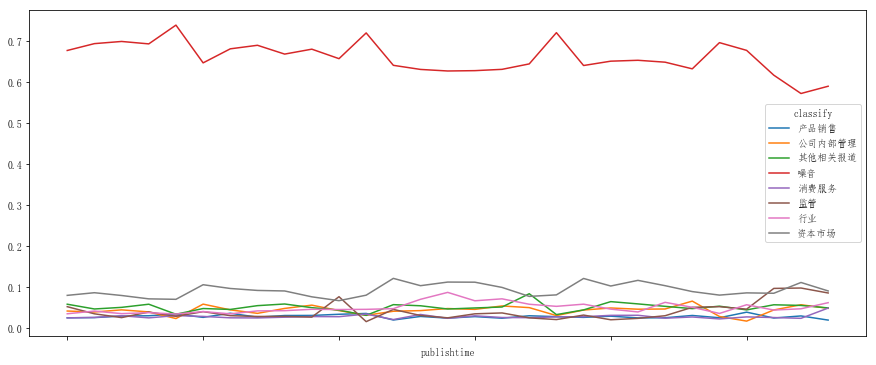

In [97]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

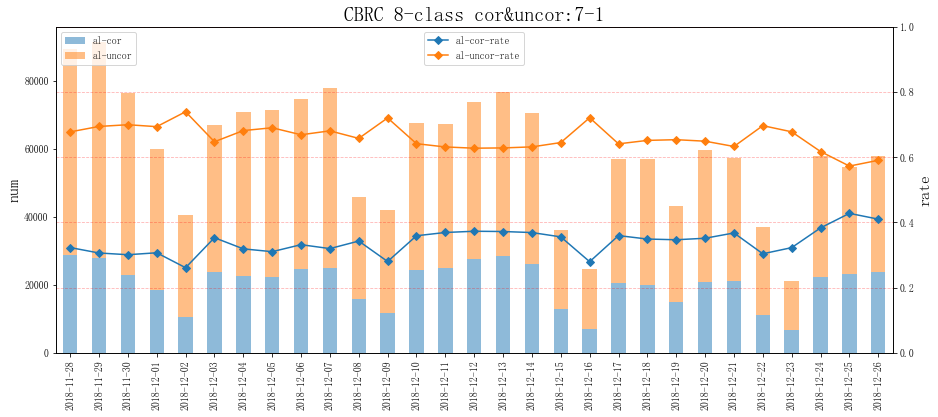

   publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-26  57932   23742     34190        0.410          0.590
27  2018-12-25  54508   23304     31204        0.428          0.572
26  2018-12-24  57920   22178     35742        0.383          0.617
25  2018-12-23  21017    6777     14240        0.322          0.678
24  2018-12-22  36865   11192     25673        0.304          0.696


In [98]:
plot_cor(count_data_7, cbirc_day_thing, "CBRC 8-class cor&uncor:7-1")

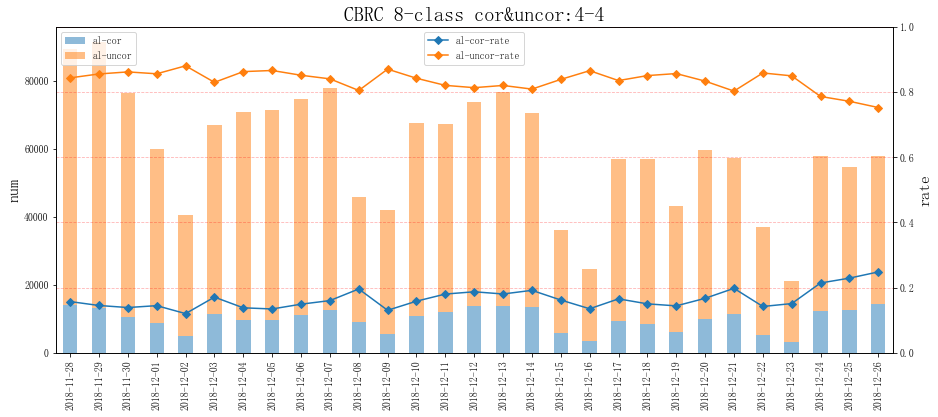

   publishtime  al_uncor    sum  al_cor  al_cor_rate  al_uncor_rate
28  2018-12-26     43566  57932   14366        0.248          0.752
27  2018-12-25     42032  54508   12476        0.229          0.771
26  2018-12-24     45522  57920   12398        0.214          0.786
25  2018-12-23     17846  21017    3171        0.151          0.849
24  2018-12-22     31629  36865    5236        0.142          0.858


In [99]:
plot_cor(count_data_4, cbirc_day_thing, "CBRC 8-class cor&uncor:4-4")

### 保监会

In [100]:
class_count = cbirc_count[cbirc_count['type'] == '保监会'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                  总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业  资本市场                 
publishtime                                                                    
2018-12-26    310    636    552  36103  1436  2279  1131  2963  45410   9307   
2018-12-25    419    581    384  39365  2105  2714  1396  2857  49821  10456   
2018-12-24    505   1226    546  41733  1339  3532  1420  3700  54001  12268   
2018-12-23    182    120     73  19777   981  2151   419  1137  24840   5063   
2018-12-22    303   1499     98  26385  1061  1826   756  2010  33938   7553   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2018-12-26   0.205 0.795  
2018-12-25   0.210 0.790  
2018-12-24   0.227 0.773  
2018-12-23   0.204 0.796  
2018-12-22   0.223 0.777

count                                                  总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业  资本市场         产品销售   
publishtime                                                                   
2018-12-26    310    636    552  36103  1436  2279  1131  2963  45410 0.007   
2018-12-25    419    581    384  39365  2105  2714  1396  2857  49821 0.008   
2018-12-24    505   1226    546  41733  1339  3532  1420  3700  54001 0.009   
2018-12-23    182    120     73  19777   981  2151   419  1137  24840 0.007   
2018-12-22    303   1499     98  26385  1061  1826   756  2010  33938 0.009   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-12-26   0.014  0.012 0.795 0.032 0.050 0.025 0.065  
2018-12-25   0.012  0.008 0.790 0.042 0.054 0.028 0.057  
2018-12-24   0.023  0.010 0.773 0.025 0.065 0.026 0.069  
2018-12-23   0.005  0.003 0.796 0.039 0.087 0.017 0.046  
2018-12-22   0.044  0.003 0.777 0.031 0.054 0.022 0.059

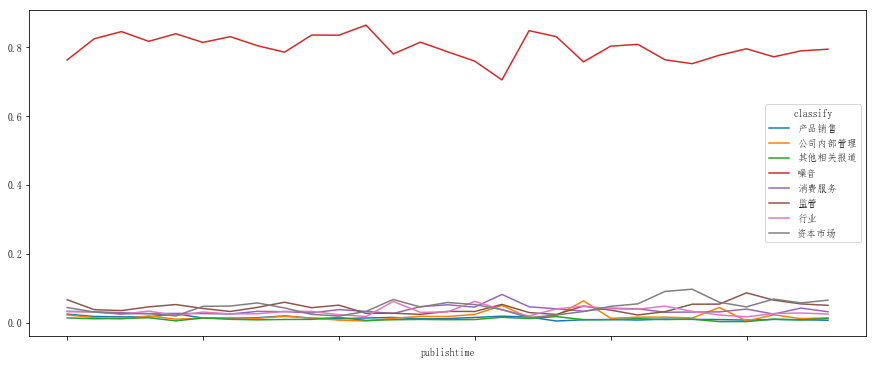

In [101]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

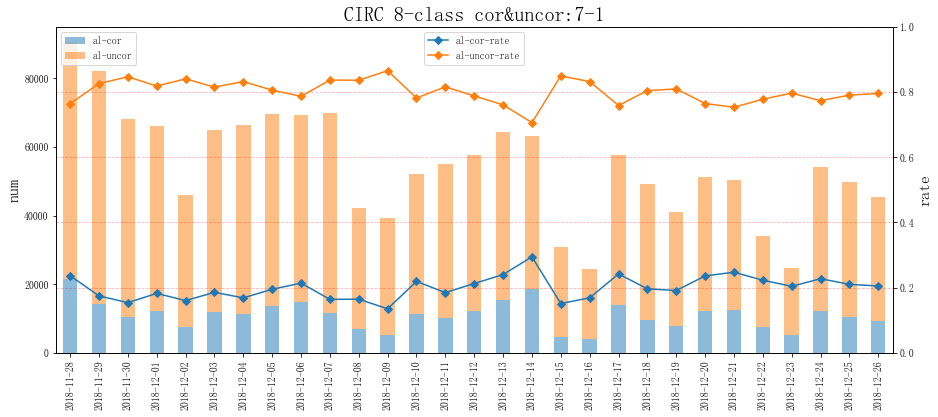

   publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-26  45410    9307     36103        0.205          0.795
27  2018-12-25  49821   10456     39365        0.210          0.790
26  2018-12-24  54001   12268     41733        0.227          0.773
25  2018-12-23  24840    5063     19777        0.204          0.796
24  2018-12-22  33938    7553     26385        0.223          0.777


In [102]:
plot_cor(count_data_7, cbirc_day_thing, "CIRC 8-class cor&uncor:7-1")

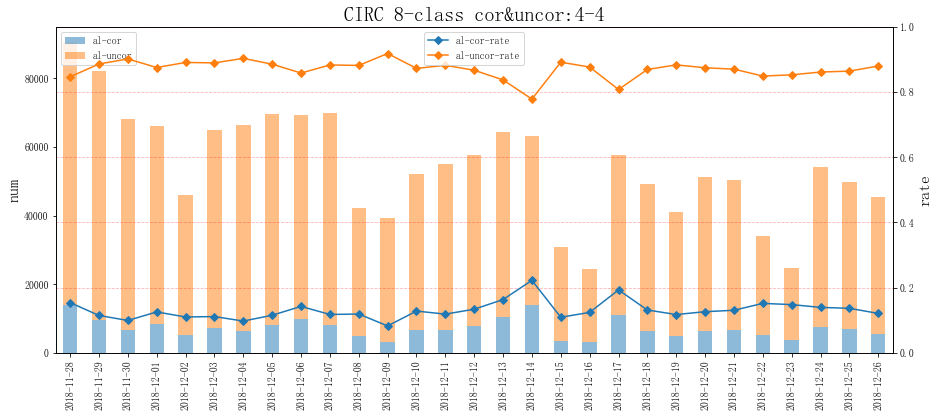

   publishtime  al_uncor    sum  al_cor  al_cor_rate  al_uncor_rate
28  2018-12-26     39928  45410    5482        0.121          0.879
27  2018-12-25     43025  49821    6796        0.136          0.864
26  2018-12-24     46484  54001    7517        0.139          0.861
25  2018-12-23     21169  24840    3671        0.148          0.852
24  2018-12-22     28796  33938    5142        0.152          0.848


In [103]:
plot_cor(count_data_4, cbirc_day_thing, "CIRC 8-class cor&uncor:4-4")

### 中国人寿

In [104]:
class_count = cbirc_count[cbirc_count['type'] == '中国人寿'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                           总量   非噪音 非噪音-比例  \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务  监管   行业 资本市场                      
publishtime                                                                   
2018-12-26     34     37     27  1457   21  71  125  142  1914   457  0.239   
2018-12-25     25     35     14  1766   40  49  191  295  2415   649  0.269   
2018-12-24     36    250     48  2460   61  86  617  103  3661  1201  0.328   
2018-12-23      3     11      2   554    4   8  118   26   726   172  0.237   
2018-12-22      3     73      8  1098   17  16  260   34  1509   411  0.272   

            噪音-比例  
classify           
publishtime        
2018-12-26  0.761  
2018-12-25  0.731  
2018-12-24  0.672  
2018-12-23  0.763  
2018-12-22  0.728

count                                           总量  rate         \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务  监管   行业 资本市场        产品销售 公司内部管理   
publishtime                                                                   
2018-12-26     34     37     27  1457   21  71  125  142  1914 0.018  0.019   
2018-12-25     25     35     14  1766   40  49  191  295  2415 0.010  0.014   
2018-12-24     36    250     48  2460   61  86  617  103  3661 0.010  0.068   
2018-12-23      3     11      2   554    4   8  118   26   726 0.004  0.015   
2018-12-22      3     73      8  1098   17  16  260   34  1509 0.002  0.048   

                                                  
classify    其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                       
2018-12-26   0.014 0.761 0.011 0.037 0.065 0.074  
2018-12-25   0.006 0.731 0.017 0.020 0.079 0.122  
2018-12-24   0.013 0.672 0.017 0.023 0.169 0.028  
2018-12-23   0.003 0.763 0.006 0.011 0.163 0.036  
2018-12-22   0.005 0.728 0.011 0.011 0.172 0.023

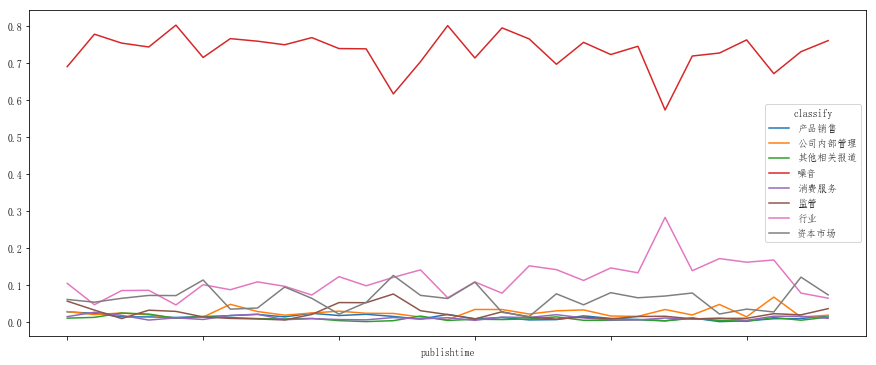

In [105]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

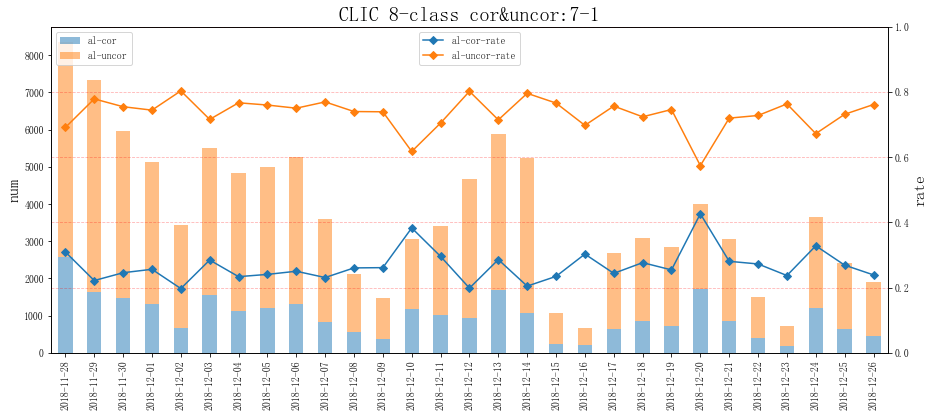

   publishtime   sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-26  1914     457      1457        0.239          0.761
27  2018-12-25  2415     649      1766        0.269          0.731
26  2018-12-24  3661    1201      2460        0.328          0.672
25  2018-12-23   726     172       554        0.237          0.763
24  2018-12-22  1509     411      1098        0.272          0.728


In [106]:
plot_cor(count_data_7, cbirc_day_thing, "CLIC 8-class cor&uncor:7-1")

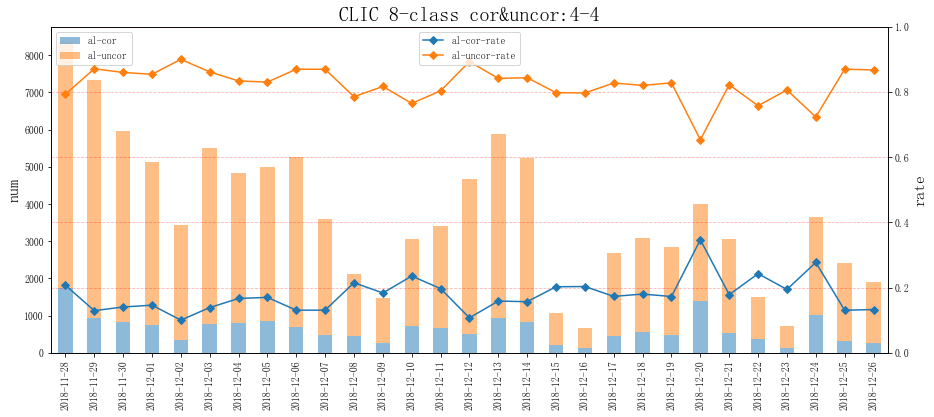

   publishtime  al_uncor   sum  al_cor  al_cor_rate  al_uncor_rate
28  2018-12-26      1660  1914     254        0.133          0.867
27  2018-12-25      2100  2415     315        0.130          0.870
26  2018-12-24      2647  3661    1014        0.277          0.723
25  2018-12-23       585   726     141        0.194          0.806
24  2018-12-22      1143  1509     366        0.243          0.757


In [107]:
plot_cor(count_data_4, cbirc_day_thing, "CLIC 8-class cor&uncor:4-4")

### 建行北分

In [108]:
class_count = cbirc_count[cbirc_count['type'] == '建行北分'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                             总量   非噪音 非噪音-比例  \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务    监管   行业 资本市场                      
publishtime                                                                     
2018-12-26    128    364    298  3398  296   843  459  522  6308  2910  0.461   
2018-12-25    127    462    251  4553  112  1046  521  497  7569  3016  0.398   
2018-12-24    157    372    222  5030  109   783  438  856  7967  2937  0.369   
2018-12-23     84     65     53  2662   69   214  329  247  3723  1061  0.285   
2018-12-22    120    390    168  3043   72   494  274  321  4882  1839  0.377   

            噪音-比例  
classify           
publishtime        
2018-12-26  0.539  
2018-12-25  0.602  
2018-12-24  0.631  
2018-12-23  0.715  
2018-12-22  0.623

count                                             总量  rate         \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务    监管   行业 资本市场        产品销售 公司内部管理   
publishtime                                                                     
2018-12-26    128    364    298  3398  296   843  459  522  6308 0.020  0.058   
2018-12-25    127    462    251  4553  112  1046  521  497  7569 0.017  0.061   
2018-12-24    157    372    222  5030  109   783  438  856  7967 0.020  0.047   
2018-12-23     84     65     53  2662   69   214  329  247  3723 0.023  0.017   
2018-12-22    120    390    168  3043   72   494  274  321  4882 0.025  0.080   

                                                  
classify    其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                       
2018-12-26   0.047 0.539 0.047 0.134 0.073 0.083  
2018-12-25   0.033 0.602 0.015 0.138 0.069 0.066  
2018-12-24   0.028 0.631 0.014 0.098 0.055 0.107  
2018-12-23   0.014 0.715 0.019 0.057 0.088 0.066  
2018-12-22   0.034 0.623 0.015 0.101 0.056 0.066

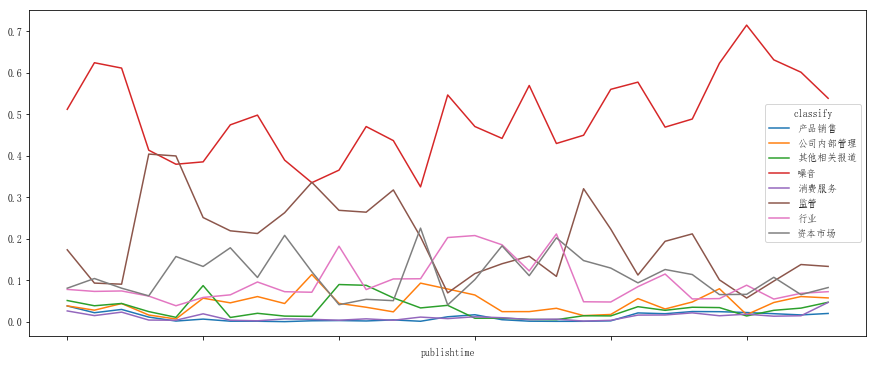

In [109]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

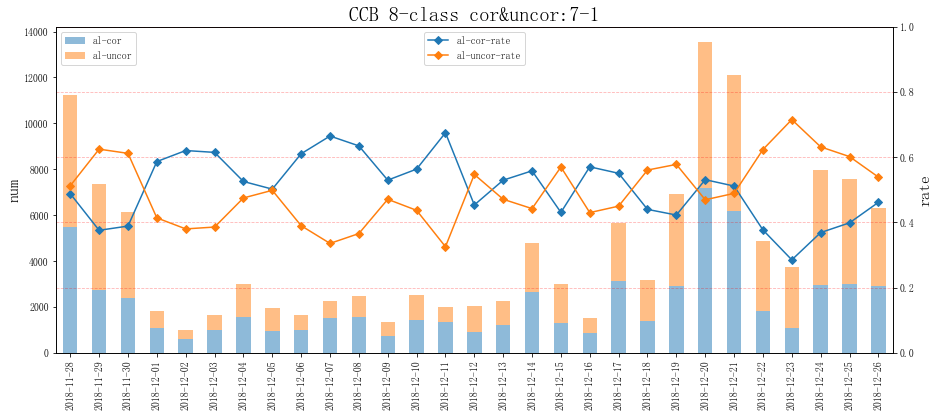

   publishtime   sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-26  6308    2910      3398        0.461          0.539
27  2018-12-25  7569    3016      4553        0.398          0.602
26  2018-12-24  7967    2937      5030        0.369          0.631
25  2018-12-23  3723    1061      2662        0.285          0.715
24  2018-12-22  4882    1839      3043        0.377          0.623


In [110]:
plot_cor(count_data_7, cbirc_day_thing, "CCB 8-class cor&uncor:7-1")

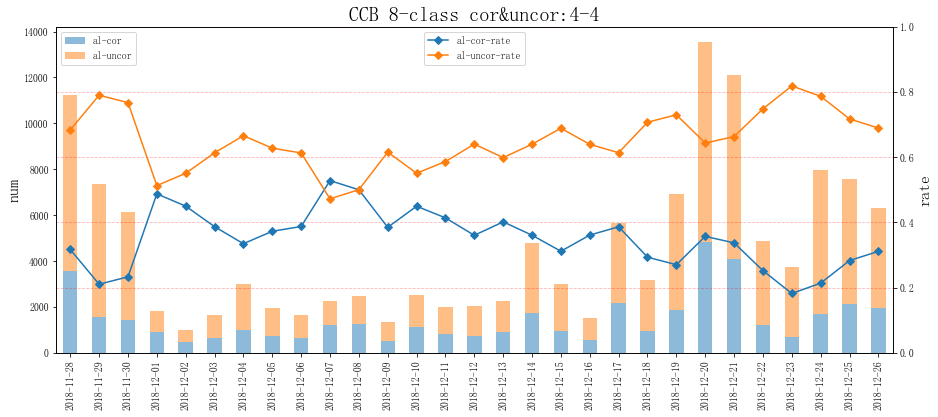

   publishtime  al_uncor   sum  al_cor  al_cor_rate  al_uncor_rate
28  2018-12-26      4346  6308    1962        0.311          0.689
27  2018-12-25      5428  7569    2141        0.283          0.717
26  2018-12-24      6265  7967    1702        0.214          0.786
25  2018-12-23      3046  3723     677        0.182          0.818
24  2018-12-22      3652  4882    1230        0.252          0.748


In [111]:
plot_cor(count_data_4, cbirc_day_thing, "CCB 8-class cor&uncor:4-4")

### 中国人保

In [112]:
class_count = cbirc_count[cbirc_count['type'] == '中国人保'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                       总量  \
classify       交通 产品销售 公司内部管理 其他相关报道    噪音 消费服务   环保   监管   行业 资本市场          
publishtime                                                                  
2018-12-26   3313   35    162    105  7572  488   91   25  205   97  12093   
2018-12-25   4295   68    184     79  4657  174  112   47  170   31   9817   
2018-12-24   4424   69    151     75  7157  123   62  158  278   59  12556   
2018-12-23   4754    6     17      9  3276   91   41   16  122   65   8397   
2018-12-22   3613    5     37     18  4529   58   80   18  210   79   8647   

              非噪音 非噪音-比例 噪音-比例  
classify                        
publishtime                     
2018-12-26   4521  0.374 0.626  
2018-12-25   5160  0.526 0.474  
2018-12-24   5399  0.430 0.570  
2018-12-23   5121  0.610 0.390  
2018-12-22   4118  0.476 0.524

count                                                    ...   \
classify       交通 产品销售 公司内部管理 其他相关报道    噪音 消费服务   环保   监管   行业 资本市场  ...    
publishtime                                                          ...    
2018-12-26   3313   35    162    105  7572  488   91   25  205   97  ...    
2018-12-25   4295   68    184     79  4657  174  112   47  170   31  ...    
2018-12-24   4424   69    151     75  7157  123   62  158  278   59  ...    
2018-12-23   4754    6     17      9  3276   91   41   16  122   65  ...    
2018-12-22   3613    5     37     18  4529   58   80   18  210   79  ...    

             rate                                                          
classify       交通  产品销售 公司内部管理 其他相关报道    噪音  消费服务    环保    监管    行业  资本市场  
publishtime                                                                
2018-12-26  0.274 0.003  0.013  0.009 0.626 0.040 0.008 0.002 0.017 0.008  
2018-12-25  0.438 0.007  0.019  0.008 0.474 0.018 0.011 0.005 0.017 0.003  
2018-12-24  0.352 0.005  0.012  0.006 0.570 0.010 0.005 0.013 0.022 0.005  
2018-12-23  0.566 0.001  0.002  0.001 0.390 0.011 0.005 0.002 0.015 0.008  
2018-12-22  0.418 0.001  0.004  0.002 0.524 0.007 0.009 0.002 0.024 0.009  

[5 rows x 21 columns]

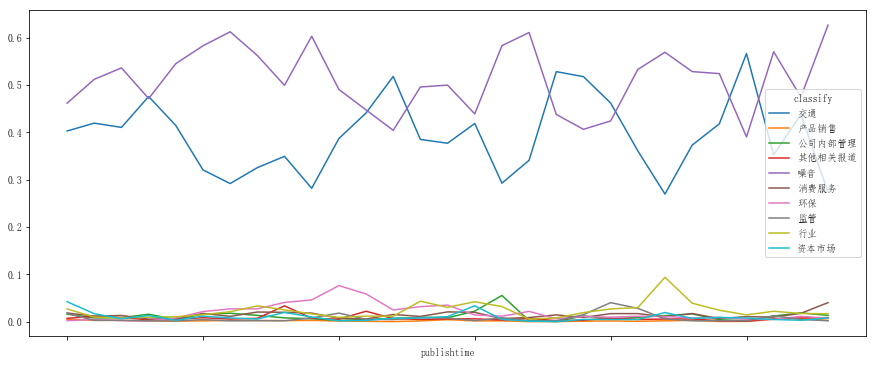

In [113]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

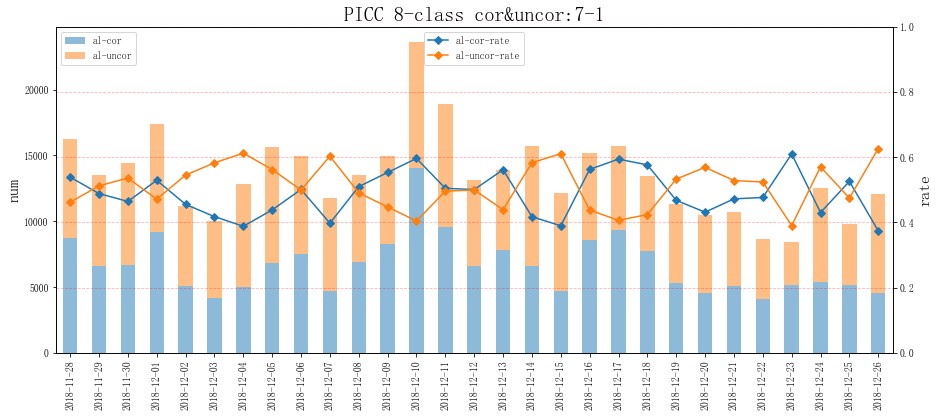

   publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-26  12093    4521      7572        0.374          0.626
27  2018-12-25   9817    5160      4657        0.526          0.474
26  2018-12-24  12556    5399      7157        0.430          0.570
25  2018-12-23   8397    5121      3276        0.610          0.390
24  2018-12-22   8647    4118      4529        0.476          0.524


In [114]:
plot_cor(count_data_7, cbirc_day_thing, "PICC 8-class cor&uncor:7-1")

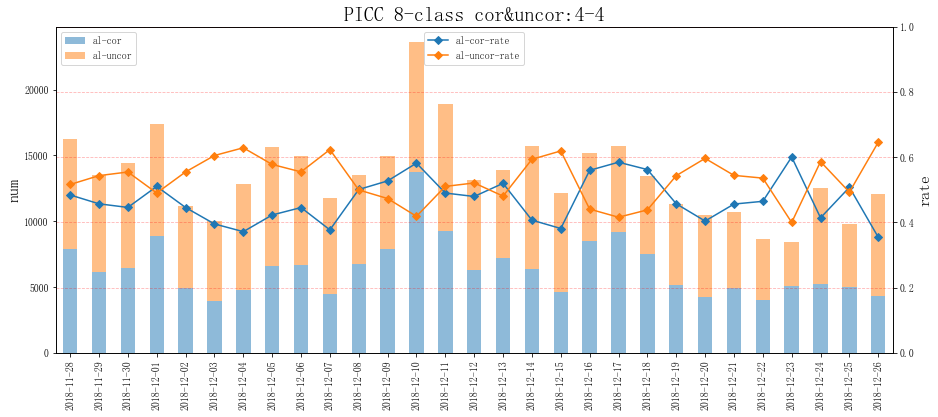

   publishtime  al_uncor    sum  al_cor  al_cor_rate  al_uncor_rate
28  2018-12-26      7809  12093    4284        0.354          0.646
27  2018-12-25      4835   9817    4982        0.507          0.493
26  2018-12-24      7360  12556    5196        0.414          0.586
25  2018-12-23      3356   8397    5041        0.600          0.400
24  2018-12-22      4631   8647    4016        0.464          0.536


In [115]:
plot_cor(count_data_4, cbirc_day_thing, "PICC 8-class cor&uncor:4-4")

## 倾向性
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：

### 银监会

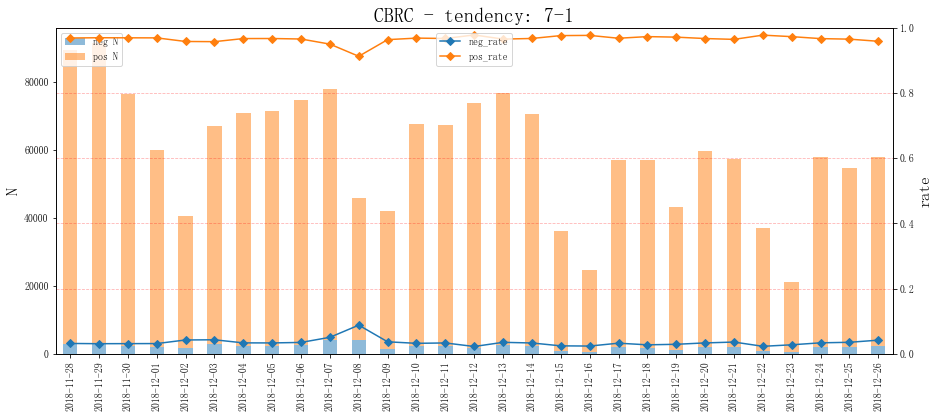

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2018-12-26  2423  55509  57932     0.042     0.958
27  2018-12-25  1923  52585  54508     0.035     0.965
26  2018-12-24  1948  55972  57920     0.034     0.966
25  2018-12-23   580  20437  21017     0.028     0.972
24  2018-12-22   847  36018  36865     0.023     0.977


In [116]:
plot_tend(tend_count[tend_count['type'] == '银监会'].drop('type', axis = 1), cbirc_day_thing, "CBRC - tendency: 7-1")

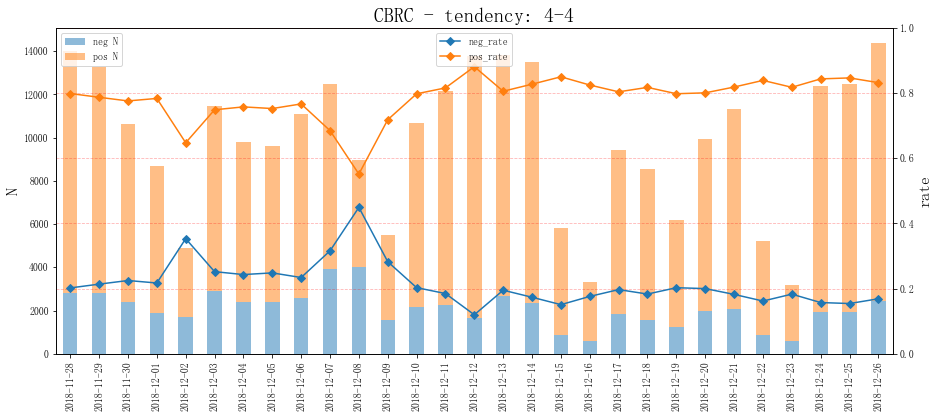

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2018-12-26  2423  11943  14366     0.169     0.831
27  2018-12-25  1923  10553  12476     0.154     0.846
26  2018-12-24  1948  10450  12398     0.157     0.843
25  2018-12-23   580   2591   3171     0.183     0.817
24  2018-12-22   847   4389   5236     0.162     0.838


In [117]:
plot_tend(tend_count_4[tend_count_4['type'] == '银监会'].drop('type', axis = 1), cbirc_day_thing, "CBRC - tendency: 4-4")

### 保监会

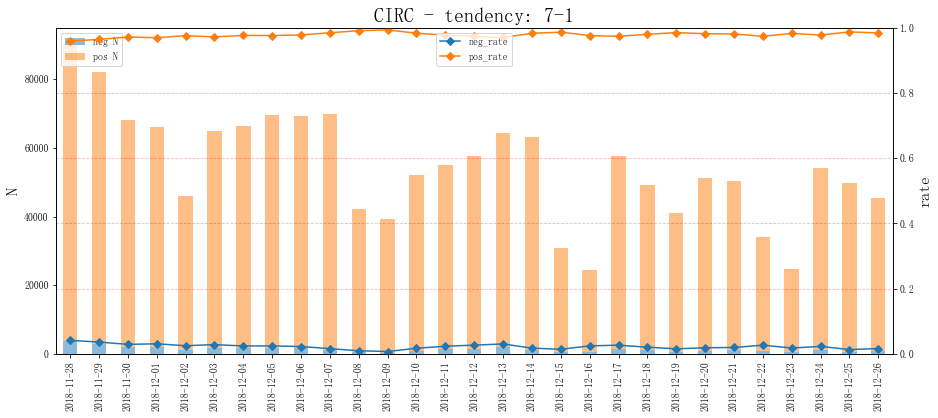

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2018-12-26   735  44675  45410     0.016     0.984
27  2018-12-25   649  49172  49821     0.013     0.987
26  2018-12-24  1223  52778  54001     0.023     0.977
25  2018-12-23   440  24400  24840     0.018     0.982
24  2018-12-22   900  33038  33938     0.027     0.973


In [118]:
plot_tend(tend_count[tend_count['type'] == '保监会'].drop('type', axis = 1), cbirc_day_thing, "CIRC - tendency: 7-1")

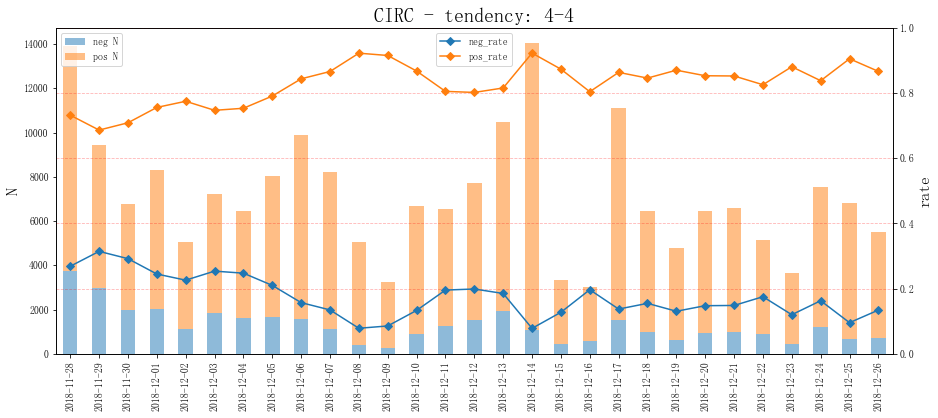

   publishtime   neg   pos   sum  neg_rate  pos_rate
28  2018-12-26   735  4747  5482     0.134     0.866
27  2018-12-25   649  6147  6796     0.095     0.905
26  2018-12-24  1223  6294  7517     0.163     0.837
25  2018-12-23   440  3231  3671     0.120     0.880
24  2018-12-22   900  4242  5142     0.175     0.825


In [119]:
plot_tend(tend_count_4[tend_count_4['type'] == '保监会'].drop('type', axis = 1), cbirc_day_thing, "CIRC - tendency: 4-4")

### 中国人寿

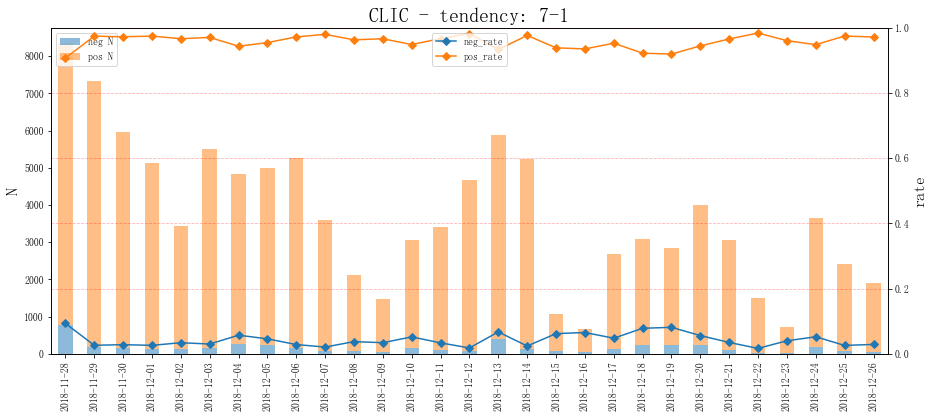

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2018-12-26   55  1859  1914     0.029     0.971
27  2018-12-25   62  2353  2415     0.026     0.974
26  2018-12-24  191  3470  3661     0.052     0.948
25  2018-12-23   29   697   726     0.040     0.960
24  2018-12-22   25  1484  1509     0.017     0.983


In [120]:
plot_tend(tend_count[tend_count['type'] == '中国人寿'].drop('type', axis = 1), cbirc_day_thing, "CLIC - tendency: 7-1")

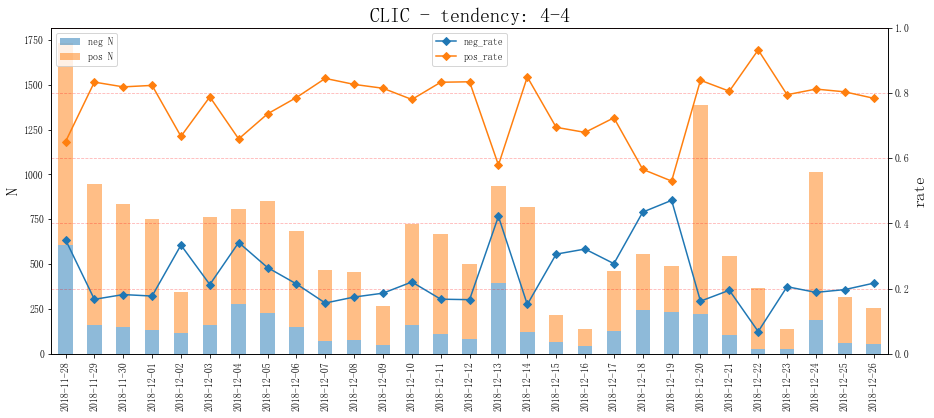

   publishtime  neg  pos   sum  neg_rate  pos_rate
28  2018-12-26   55  199   254     0.217     0.783
27  2018-12-25   62  253   315     0.197     0.803
26  2018-12-24  191  823  1014     0.188     0.812
25  2018-12-23   29  112   141     0.206     0.794
24  2018-12-22   25  341   366     0.068     0.932


In [121]:
plot_tend(tend_count_4[tend_count_4['type'] == '中国人寿'].drop('type', axis = 1), cbirc_day_thing, "CLIC - tendency: 4-4")

### 建行北分

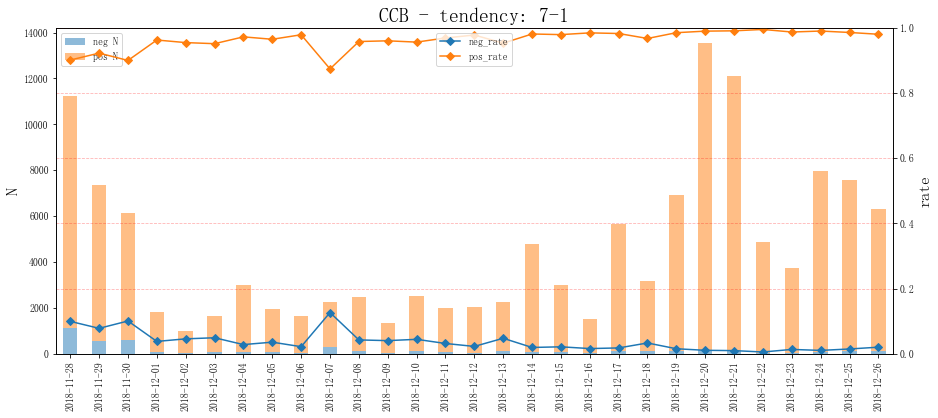

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2018-12-26  128  6180  6308     0.020     0.980
27  2018-12-25  112  7457  7569     0.015     0.985
26  2018-12-24   83  7884  7967     0.010     0.990
25  2018-12-23   50  3673  3723     0.013     0.987
24  2018-12-22   27  4855  4882     0.006     0.994


In [127]:
plot_tend(tend_count[(tend_count['type'] == '建行北分')&(tend_count['tendency'] != 1)].drop('type', axis = 1), 
          cbirc_day_thing, "CCB - tendency: 7-1")

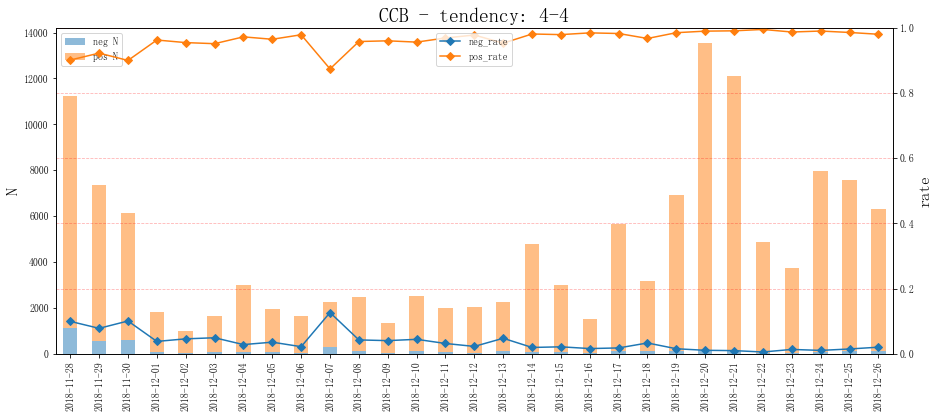

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2018-12-26  128  6180  6308     0.020     0.980
27  2018-12-25  112  7457  7569     0.015     0.985
26  2018-12-24   83  7884  7967     0.010     0.990
25  2018-12-23   50  3673  3723     0.013     0.987
24  2018-12-22   27  4855  4882     0.006     0.994


In [128]:
plot_tend(tend_count[(tend_count['type'] == '建行北分')&(tend_count['tendency'] != 1)].drop('type', axis = 1), 
          cbirc_day_thing, "CCB - tendency: 4-4")

### 中国人保

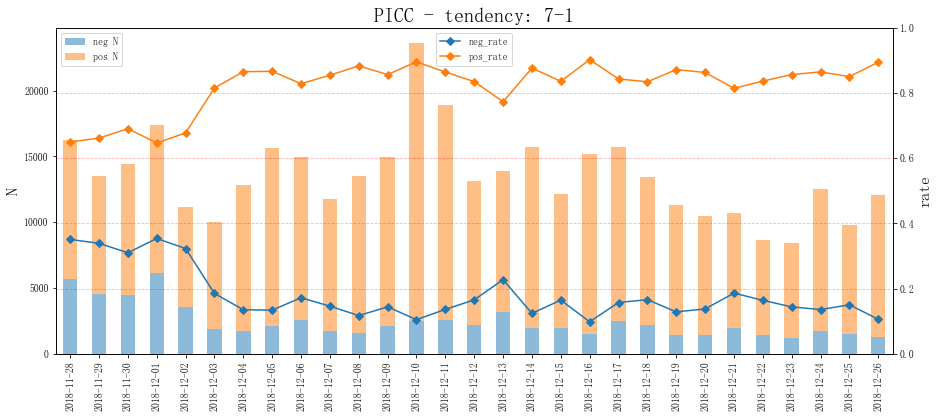

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2018-12-26  1281  10812  12093     0.106     0.894
27  2018-12-25  1475   8342   9817     0.150     0.850
26  2018-12-24  1703  10853  12556     0.136     0.864
25  2018-12-23  1208   7189   8397     0.144     0.856
24  2018-12-22  1418   7229   8647     0.164     0.836


In [129]:
plot_tend(tend_count[tend_count['type'] == '中国人保'].drop('type', axis = 1), cbirc_day_thing, "PICC - tendency: 7-1")

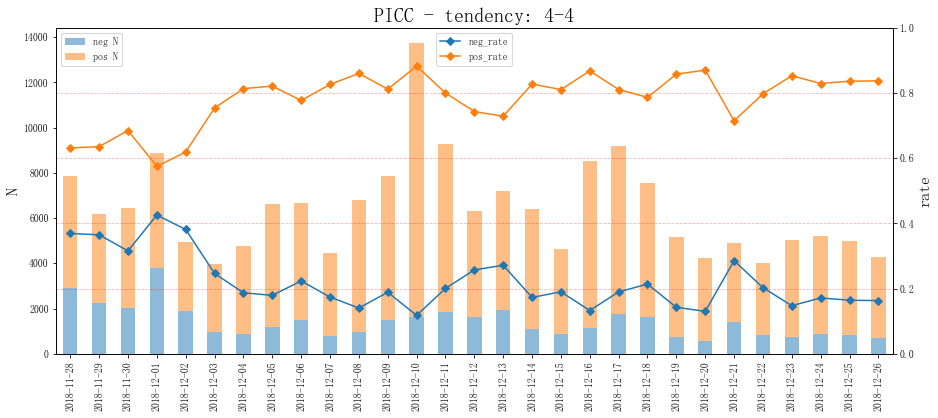

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2018-12-26  699  3585  4284     0.163     0.837
27  2018-12-25  818  4164  4982     0.164     0.836
26  2018-12-24  890  4306  5196     0.171     0.829
25  2018-12-23  743  4298  5041     0.147     0.853
24  2018-12-22  815  3201  4016     0.203     0.797


In [130]:
plot_tend(tend_count_4[tend_count_4['type'] == '中国人保'].drop('type', axis = 1), cbirc_day_thing, "PICC - tendency: 4-4")

## 补录和预警
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：

### 银监会

In [132]:
# plot_add(cbirc_add[cbirc_add['type'] == '银监会'], cbirc_day_thing, "（银监会）人工补录")

### 保监会

In [133]:
# plot_add(cbirc_add[cbirc_add['type'] == '保监会'], cbirc_day_thing, "（保监会）人工补录")

### 中国人寿

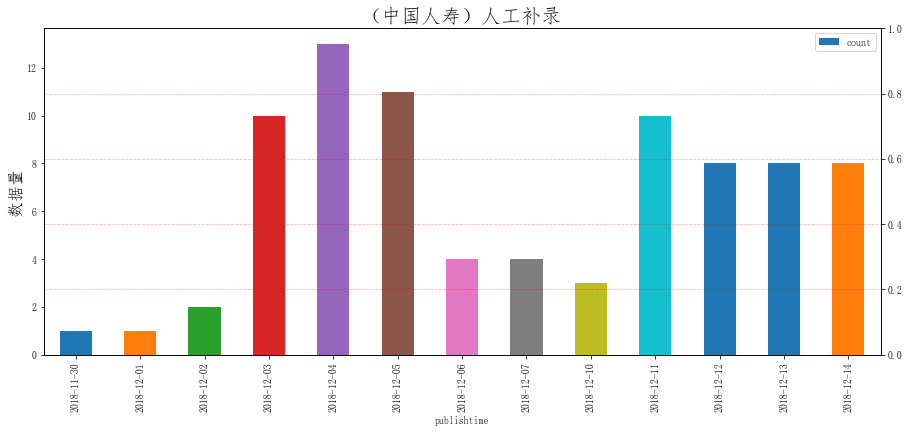

   publishtime  count
12  2018-12-14      8
11  2018-12-13      8
10  2018-12-12      8
9   2018-12-11     10
8   2018-12-10      3


In [134]:
plot_add(cbirc_add[cbirc_add['type'] == '中国人寿'], cbirc_day_thing, "（中国人寿）人工补录")

### 建行北分

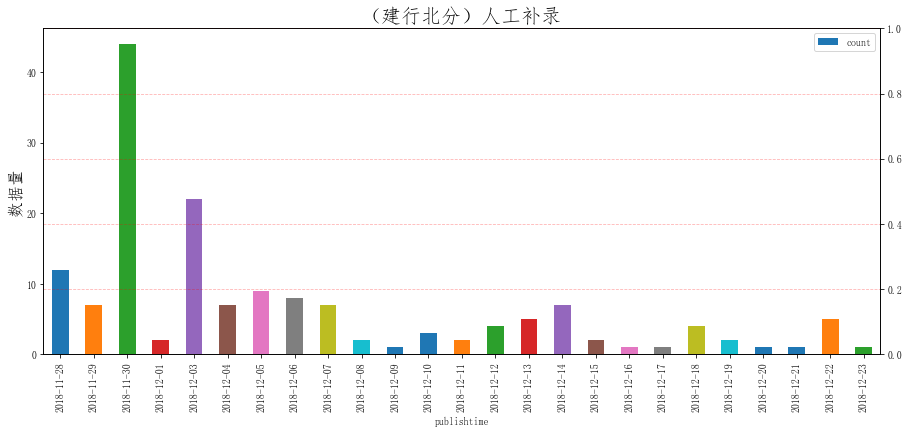

   publishtime  count
24  2018-12-23      1
23  2018-12-22      5
22  2018-12-21      1
21  2018-12-20      1
20  2018-12-19      2


In [135]:
plot_add(cbirc_add[cbirc_add['type'] == '建行北分'], cbirc_day_thing, "（建行北分）人工补录")

### 中国人保

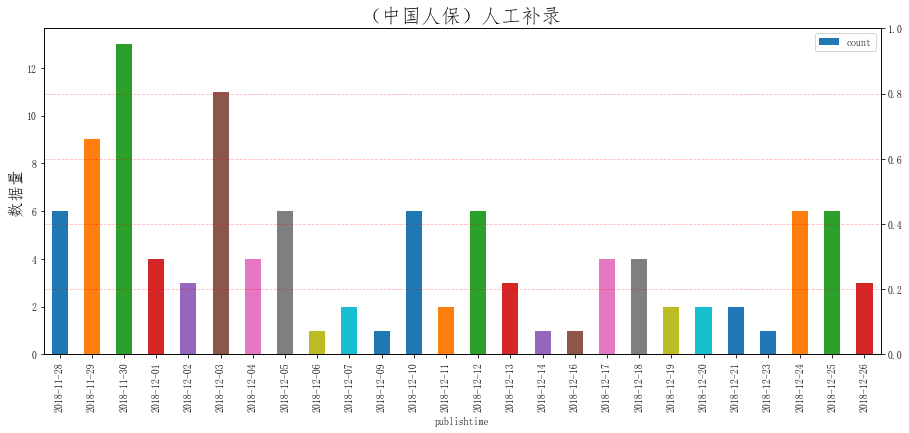

   publishtime  count
25  2018-12-26      3
24  2018-12-25      6
23  2018-12-24      6
22  2018-12-23      1
21  2018-12-21      2


In [136]:
plot_add(cbirc_add[cbirc_add['type'] == '中国人保'], cbirc_day_thing, "（中国人保）人工补录")

In [143]:
from tqdm import tqdm,trange
from time import sleep

for i in tqdm(range(10), desc='1st loop'):
    for j in trange(100, desc='2nd loop', leave=False):
        sleep(0.01)


1st loop:   0%|                                         | 0/10 [00:00<?, ?it/s]

2nd loop:   0%|                                        | 0/100 [00:00<?, ?it/s]

2nd loop:  10%|███                            | 10/100 [00:00<00:00, 99.00it/s]

2nd loop:  20%|██████▏                        | 20/100 [00:00<00:00, 95.69it/s]

2nd loop:  30%|█████████▎                     | 30/100 [00:00<00:00, 95.23it/s]

2nd loop:  40%|████████████▍                  | 40/100 [00:00<00:00, 94.78it/s]

2nd loop:  50%|███████████████▌               | 50/100 [00:00<00:00, 94.33it/s]

2nd loop:  60%|██████████████████▌            | 60/100 [00:00<00:00, 94.19it/s]

2nd loop:  70%|█████████████████████▋         | 70/100 [00:00<00:00, 94.08it/s]

2nd loop:  80%|████████████████████████▊      | 80/100 [00:00<00:00, 93.78it/s]

2nd loop:  90%|███████████████████████████▉   | 90/100 [00:00<00:00, 93.84it/s]

2nd loop: 100%|██████████████████████████████| 100/100 [00:01<00:00, 93.80it/s]

                           

2nd loop:  90%|███████████████████████████▉   | 90/100 [00:00<00:00, 92.68it/s]

2nd loop: 100%|██████████████████████████████| 100/100 [00:01<00:00, 92.50it/s]

                                                                               
1st loop:  80%|██████████████████████████▍      | 8/10 [00:08<00:02,  1.11s/it]

2nd loop:   0%|                                        | 0/100 [00:00<?, ?it/s]

2nd loop:  10%|███                            | 10/100 [00:00<00:00, 97.08it/s]

2nd loop:  20%|██████▏                        | 20/100 [00:00<00:00, 96.61it/s]

2nd loop:  30%|█████████▎                     | 30/100 [00:00<00:00, 95.54it/s]

2nd loop:  40%|████████████▍                  | 40/100 [00:00<00:00, 94.33it/s]

2nd loop:  50%|███████████████▌               | 50/100 [00:00<00:00, 93.98it/s]

2nd loop:  59%|██████████████████▎            | 59/100 [00:00<00:00, 93.35it/s]

2nd loop:  69%|█████████████████████▍         | 69/100 [00:00<00:00, 93.11it/s]

2nd loop:  79%|██████████████